In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
import re
import unicodedata
import nltk
import csv
import string
from textblob import TextBlob
from nltk.corpus import stopwords
# !pip install demoji
# nltk.download('all')
# import demoji
# !pip install sentence-transformers
# from sentence_transformers import SentenceTransformer

In [3]:
pd.options.display.max_colwidth = 250

In [4]:
!pip install --upgrade transformers==4.10.1

# !pip install -q transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 6.2 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 3.3 MB 60.0 MB/s 
     |████████████████████████████████| 880 kB 71.7 MB/s 
     |████████████████████████████████| 596 kB 59.1 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=46ec8ebbaab219453d59eac7c8690404e3d25a925bc221c93bf70e60e87ed1d8
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
SEED = 1024
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler
import torchtext
from torchtext import data

import transformers
from transformers import BertTokenizer, BertModel, BertConfig

import warnings
warnings.filterwarnings('ignore')
import operator

from sklearn.metrics import hamming_loss, jaccard_score, label_ranking_average_precision_score, f1_score
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

from matplotlib.ticker import StrMethodFormatter

In [6]:
print(transformers.__version__)

4.10.1


In [7]:
print(transformers.__version__)

4.10.1


In [8]:
MAX_LEN = 200 #based on length of tweets
TRAIN_BATCH_SIZE = 1
VALID_BATCH_SIZE = 1
EPOCHS = 4
LEARNING_RATE = 1e-05 #tried 1e-03, 1e-04, 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        self.tweet = dataframe['Tweet']
        self.targets = self.dataframe.list
        self.max_len = max_len

    def __len__(self):
        return len(self.tweet)
    
    def __getitem__(self, index):
        tweet = str(self.tweet[index])
        tweet = " ".join(tweet.split())

        inputs = self.tokenizer.encode_plus(
            tweet,
            None,
            add_special_tokens = True,
            max_length = self.max_len,
            pad_to_max_length = True,
            return_token_type_ids = True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        return {
            'ids' : torch.tensor(ids, dtype = torch.long),
            'mask' : torch.tensor(mask, dtype = torch.long),
            'token_type_ids' : torch.tensor(token_type_ids, dtype = torch.long),
            'targets' : torch.tensor(self.targets[index], dtype = torch.float)
        }

In [10]:
class BERT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.layer2 = torch.nn.Dropout(0.3)
        self.layer3 = torch.nn.Linear(768, 11)

    def forward(self, ids, mask, token_type_ids, return_dict = False):
        unw, out_1 = self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[0], self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[1]
        out_2 = self.layer2(out_1)
        out_final = self.layer3(out_2)
        return out_final

model = BERT()
model.to(device)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

In [11]:
bert = torch.load("/content/drive/MyDrive/religious_texts/bertmodel.pth")
bert

BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

# Saving Weights

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/religious_texts/weights_only.pth')

# Loading Weights

In [ ]:
model_new = BERT()
model_new.to(device)

model_new.load_state_dict(torch.load('/content/drive/MyDrive/religious_texts/weights_only.pth'))

model_new

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

In [ ]:
model_new

In [12]:
def test():
    bert.eval()
    bert_outputs = []

    with torch.no_grad():
        for unw, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = bert(ids, mask, token_type_ids)

            bert_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return bert_outputs

# Creating Dataframe of Verses

In [ ]:
for chapter in range(13, 14):
  filename = '/content/drive/MyDrive/religious_texts/mahatma gandhi/chap ' + str(chapter) + ' modified.txt'
  
  with open(filename) as fh:
    content = fh.read()

    content_list = content.splitlines()
    content_list2 = []

    for line in content_list:
      remove_digits = str.maketrans('', '', digits)
      res = line.translate(remove_digits)

      content_list2.append(res)
        
    fh.close()
    
    print(len(content_list2))
  
  df = pd.DataFrame(content_list2, columns=['verse'])
  df.to_csv("/content/drive/MyDrive/religious_texts/mahatma gandhi/csv folder/" + str(chapter) + ".csv")

# Predicting Sentiments

In [ ]:
for chapter in range(18, 19):

  new_df = pd.DataFrame()

  verses_df = pd.read_csv('/content/drive/MyDrive/religious_texts/purohit swami/csv folder/' + str(chapter) + '.csv')

  new_df['Tweet'] = verses_df['verse']
  values = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] * len(verses_df)
  new_df['list'] = values

  test_dataset = CustomDataset(new_df, tokenizer, MAX_LEN)

  bert_test_params = {'batch_size': 1,
                    'shuffle': False,
                    'num_workers': 0
                    }   

  test_loader = DataLoader(test_dataset, **bert_test_params)

  test_outputs = test()

  test_outputs = np.array(test_outputs)

  for i in range(test_outputs.shape[0]):
      for j in range(test_outputs.shape[1]):
          if test_outputs[i][j] >= 0.5: test_outputs[i][j] = 1
          else: test_outputs[i][j] = 0

  new_df['Optimistic'] = "None"
  new_df['Thankful'] = "None"
  new_df['Empathetic'] = "None"
  new_df['Pessimistic'] = "None"
  new_df['Anxious'] = "None"
  new_df['Sad'] = "None"
  new_df['Annoyed'] = "None"
  new_df['Denial'] = "None"
  new_df['Official report'] = "None"
  new_df['Surprise'] = "None"
  new_df['Joking'] = "None"
  new_df = new_df.drop(['list'], axis = 1)

  for i in range(len(test_outputs)):
    new_df['Optimistic'].iloc[i] = test_outputs[i][0]
    new_df['Thankful'].iloc[i] = test_outputs[i][1]
    new_df['Empathetic'].iloc[i] = test_outputs[i][2]
    new_df['Pessimistic'].iloc[i] = test_outputs[i][3]
    new_df['Anxious'].iloc[i] = test_outputs[i][4]
    new_df['Sad'].iloc[i] = test_outputs[i][5]
    new_df['Annoyed'].iloc[i] = test_outputs[i][6]
    new_df['Denial'].iloc[i] = test_outputs[i][7]
    new_df['Official report'].iloc[i] = test_outputs[i][8]
    new_df['Surprise'].iloc[i] = test_outputs[i][9]
    new_df['Joking'].iloc[i] = test_outputs[i][10]

    new_df.tail(5)

    new_df.to_csv('/content/drive/MyDrive/religious_texts/purohit swami/predicted sentiment/chapter ' + str(chapter))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


# Cumulative sentiments of all chapters plotted using bar plots

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

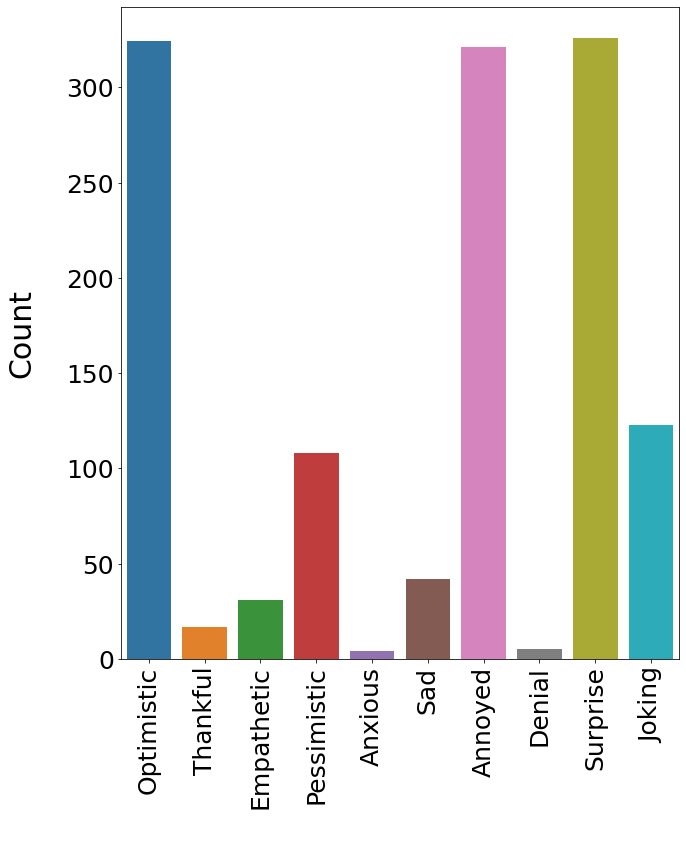

In [ ]:
total_df = pd.DataFrame()

for chapter in range(1,19):
  df = pd.read_csv('/content/drive/MyDrive/religious_texts/purohit swami/predicted sentiment/chapter ' + str(chapter))

  df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
  df = df.apply(pd.Series.value_counts)

  df['Optimistic'] = df['Optimistic'].fillna(0)
  df['Thankful'] = df['Thankful'].fillna(0)
  df['Empathetic'] = df['Empathetic'].fillna(0)
  df['Pessimistic'] = df['Pessimistic'].fillna(0)
  df['Anxious'] = df['Anxious'].fillna(0)
  df['Sad'] = df['Sad'].fillna(0)
  df['Annoyed'] = df['Annoyed'].fillna(0)
  df['Denial'] = df['Denial'].fillna(0)
  #df['Official report'] = df['Official report'].fillna(0)
  df['Surprise'] = df['Surprise'].fillna(0)
  df['Joking'] = df['Joking'].fillna(0)

  df = df.iloc[1]

  df = pd.DataFrame(df)

  df.columns = [ 'Count']

  total_df = total_df.append(df)

total_df = total_df.reset_index()
total_df = total_df.rename(columns={"index":"Sentiment"})

new_df = pd.DataFrame({"Sentiment":["Optimistic", "Thankful", "Empathetic", "Pessimistic", "Anxious", "Sad", "Annoyed", "Denial", "Surprise", "Joking"], 
                       "Count":[0,0,0,0,0,0,0,0,0,0,]})

for ii in range(0, 10):
  for jj in range(0, 18):
    new_df.loc[ii, 'Count'] = (new_df.loc[ii, 'Count'] + total_df.loc[jj*10+ii, 'Count']).astype(int)

fig_dims = (10, 12)
fig, ax = plt.subplots(figsize=fig_dims)


sns.barplot(x = new_df.Sentiment, y = new_df.Count, ax = ax, palette = sns.color_palette("tab10"))

plt.xticks(rotation=90)

plt.ylabel('Count', labelpad=30)
plt.xlabel(' ')
# plt.title('All Chapters', fontsize = 25,  pad=25)
ax.xaxis.label.set_size(30)
ax.yaxis.label.set_size(30)

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))    # format decimals on the y-axis
plt.yticks(fontsize= 25)
plt.xticks(fontsize = 25)

# All chapter Bar plots

In [ ]:
def all_chapter_dataframe(path):
  total_df = pd.DataFrame()

  for chapter in range(1,19):
    df = pd.read_csv(path + str(chapter))

    df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
    df = df.apply(pd.Series.value_counts)

    df['Optimistic'] = df['Optimistic'].fillna(0)
    df['Thankful'] = df['Thankful'].fillna(0)
    df['Empathetic'] = df['Empathetic'].fillna(0)
    df['Pessimistic'] = df['Pessimistic'].fillna(0)
    df['Anxious'] = df['Anxious'].fillna(0)
    df['Sad'] = df['Sad'].fillna(0)
    df['Annoyed'] = df['Annoyed'].fillna(0)
    df['Denial'] = df['Denial'].fillna(0)
    #df['Official report'] = df['Official report'].fillna(0)
    df['Surprise'] = df['Surprise'].fillna(0)
    df['Joking'] = df['Joking'].fillna(0)

    df = df.iloc[1]

    df = pd.DataFrame(df)

    df.columns = [ 'Count']

    total_df = total_df.append(df)
  
  total_df = total_df.reset_index()
  total_df = total_df.rename(columns={"index":"Sentiment"})

  new_df = pd.DataFrame({"Sentiment":["Optimistic", "Thankful", "Empathetic", "Pessimistic", "Anxious", "Sad", "Annoyed", "Denial", "Surprise", "Joking"], 
                       "Count":[0,0,0,0,0,0,0,0,0,0,]})

  for ii in range(0, 10):
    for jj in range(0, 18):
      new_df.loc[ii, 'Count'] = (new_df.loc[ii, 'Count'] + total_df.loc[jj*10+ii, 'Count']).astype(int)

  return new_df

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

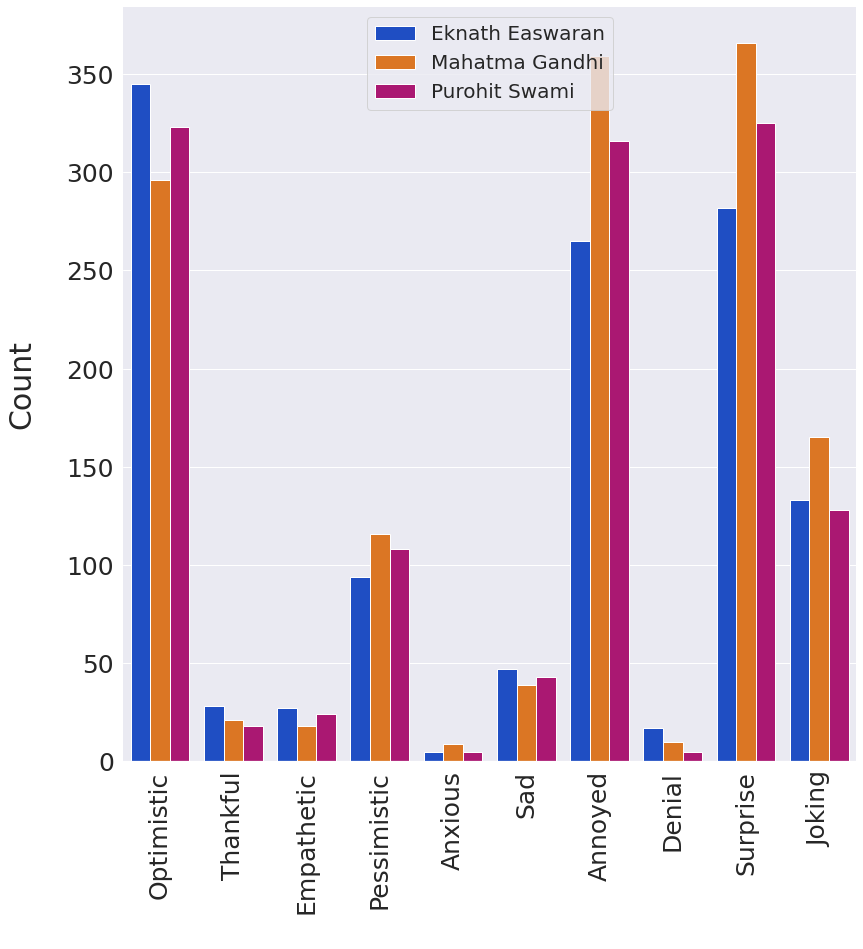

In [ ]:
eknath_easwaran = all_chapter_dataframe('/content/drive/MyDrive/religious_texts/eknath easwaran/predicted sentiment/chapter ')
mahatma_gandhi = all_chapter_dataframe('/content/drive/MyDrive/religious_texts/mahatma gandhi/predicted sentiment/chapter ')
purohit_swami = all_chapter_dataframe('/content/drive/MyDrive/religious_texts/purohit swami/predicted sentiment/chapter ')

df_new = pd.concat([eknath_easwaran, mahatma_gandhi['Count'], purohit_swami['Count']], axis=1)

df_new.columns = ['Sentiment', 'Eknath Easwaran', 'Mahatma Gandhi', 'Purohit Swami']

df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")

# sns.color_palette("tab10")

# sns.factorplot(x='Sentiment', y='Count', hue='Author', data=df_new, kind='bar', height=10, palette = "tab10")

colors = ["blue", "orange", "magenta"]  
myPalette = sns.xkcd_palette(colors)

sns.set_style("darkgrid")
g = sns.factorplot(x='Sentiment', y='Count', hue='Author', data=df_new, kind='bar', height=12, palette = myPalette, legend=False)

g.despine(left=True)

plt.legend(loc='upper center',prop={"size":20})

plt.ylabel('Count', labelpad=30, fontsize=30)
plt.xlabel(' ')

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))    # format decimals on the y-axis
plt.yticks(fontsize= 25)
plt.xticks(fontsize = 25)
plt.xticks(rotation=90)



# Chapter-wise sentiments

In [ ]:
def chapter_wise_dataframe(path, chapter):
  
    df = pd.read_csv(path + str(chapter))

    df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
    df = df.apply(pd.Series.value_counts)

    df['Optimistic'] = df['Optimistic'].fillna(0)
    df['Thankful'] = df['Thankful'].fillna(0)
    df['Empathetic'] = df['Empathetic'].fillna(0)
    df['Pessimistic'] = df['Pessimistic'].fillna(0)
    df['Anxious'] = df['Anxious'].fillna(0)
    df['Sad'] = df['Sad'].fillna(0)
    df['Annoyed'] = df['Annoyed'].fillna(0)
    df['Denial'] = df['Denial'].fillna(0)
    #df['Official report'] = df['Official report'].fillna(0)
    df['Surprise'] = df['Surprise'].fillna(0)
    df['Joking'] = df['Joking'].fillna(0)

    df = df.iloc[1]

    df = pd.DataFrame(df)

    df.columns = [ 'Count']

    return df

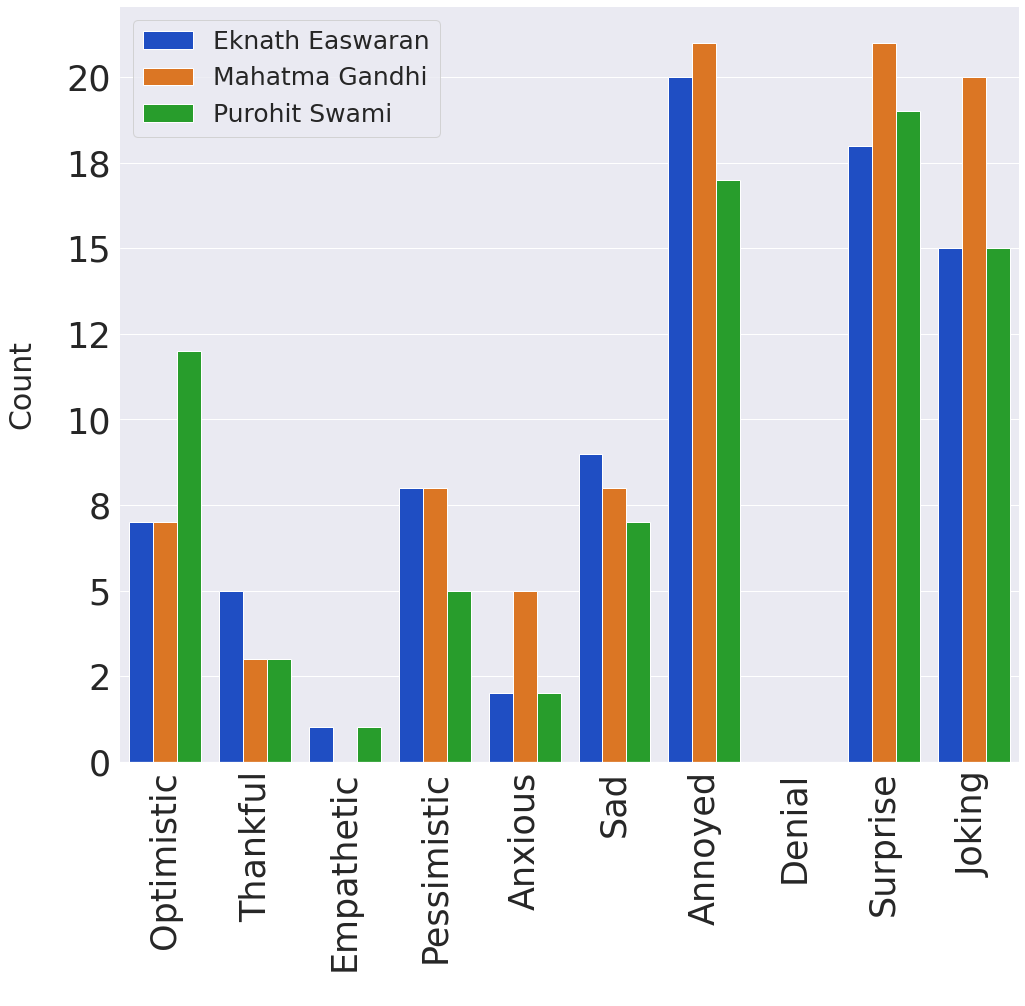

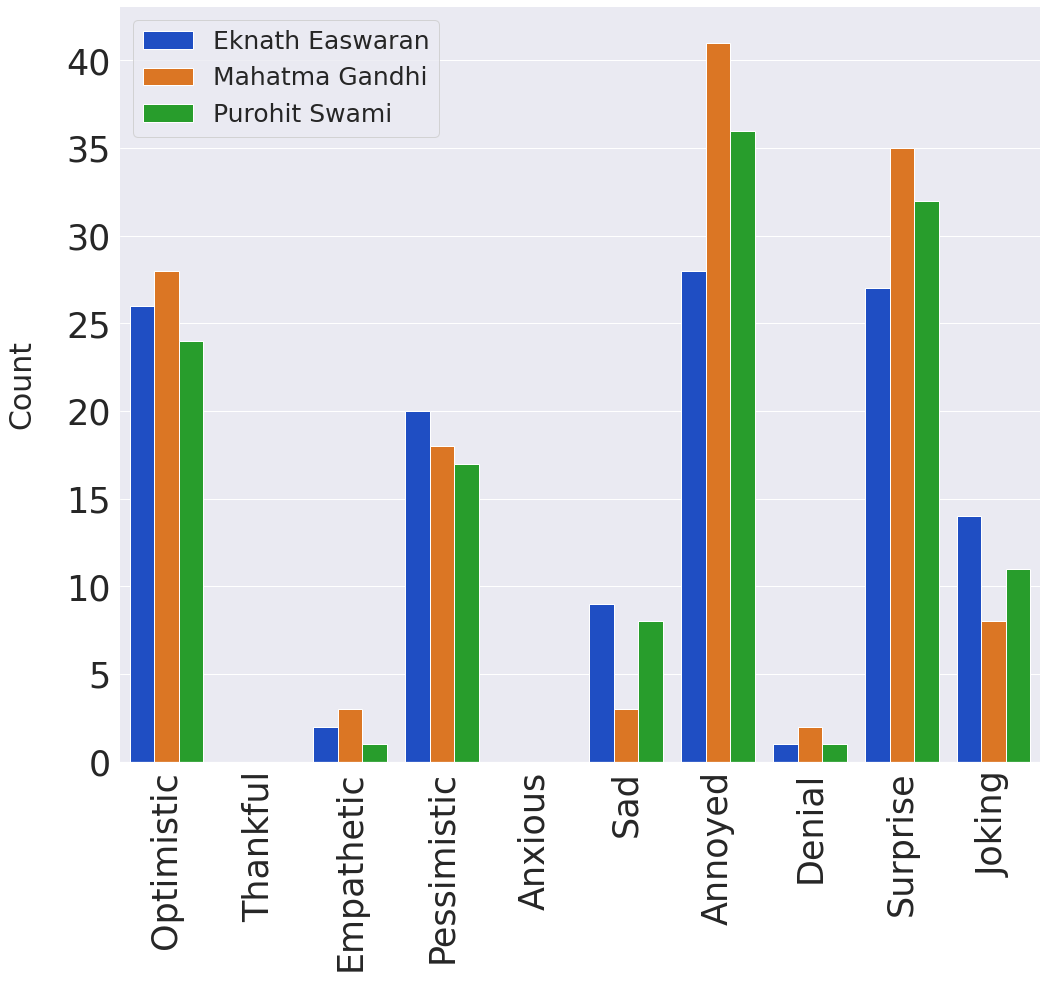

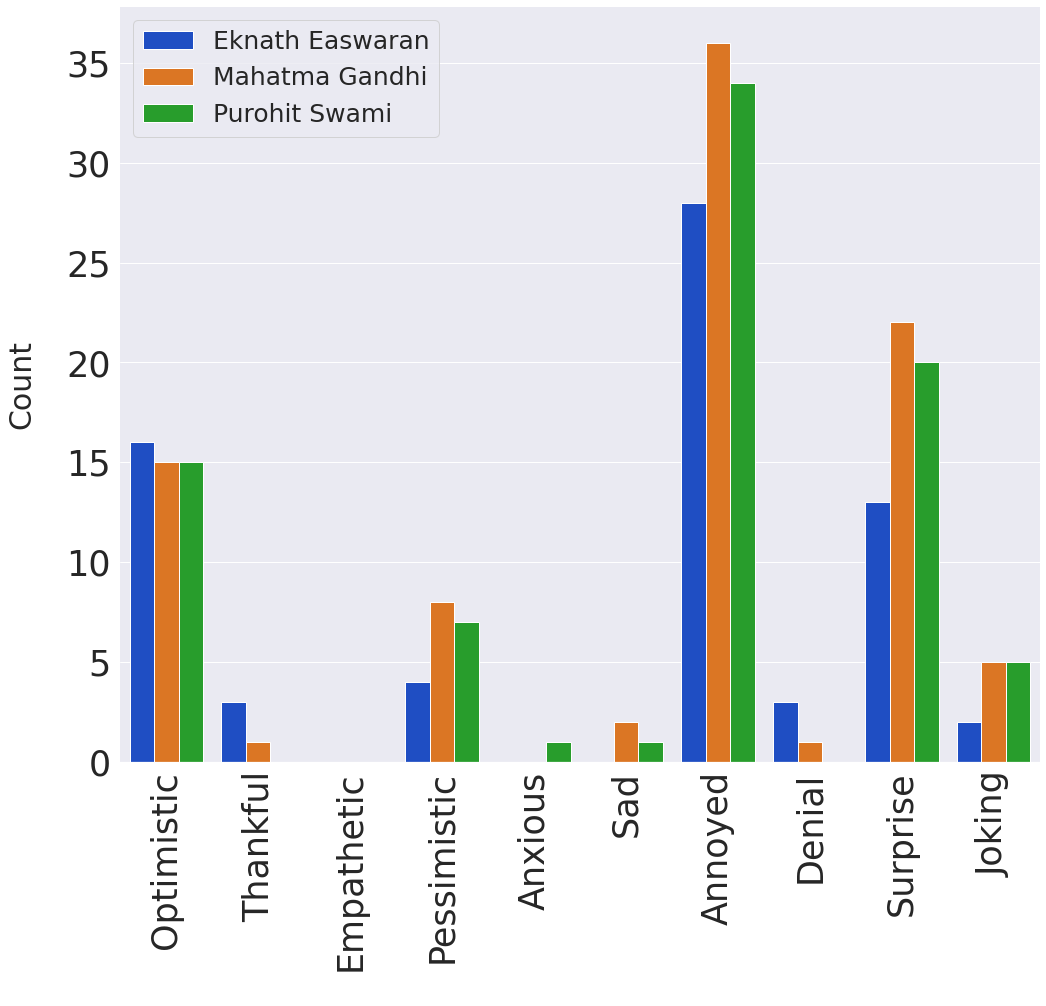

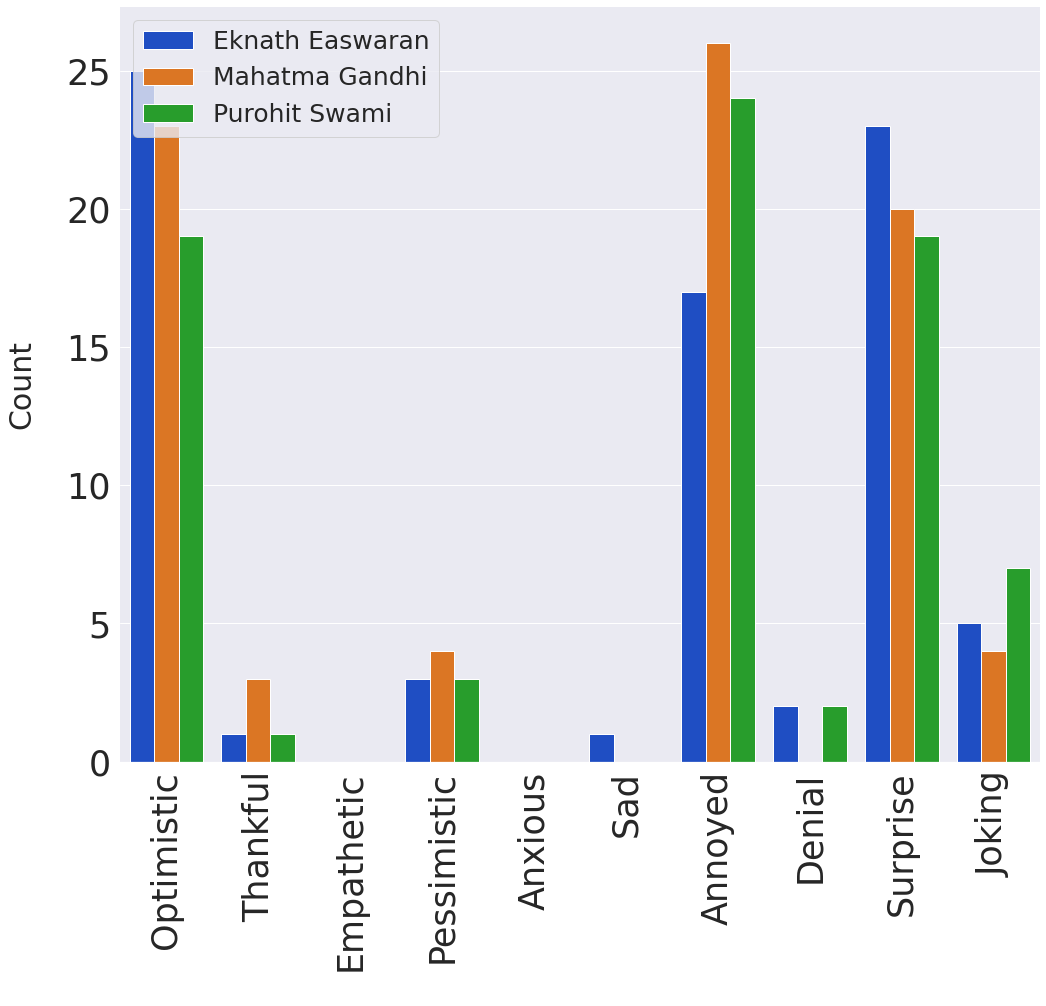

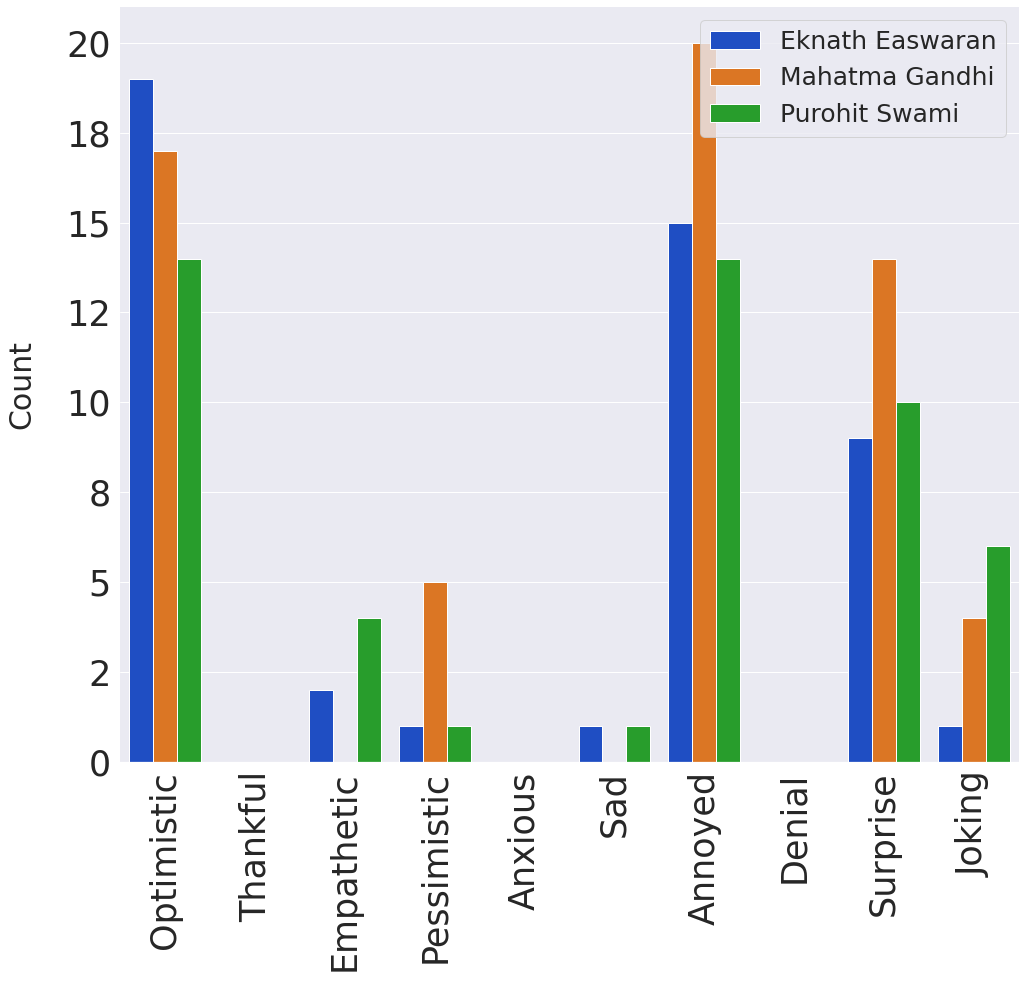

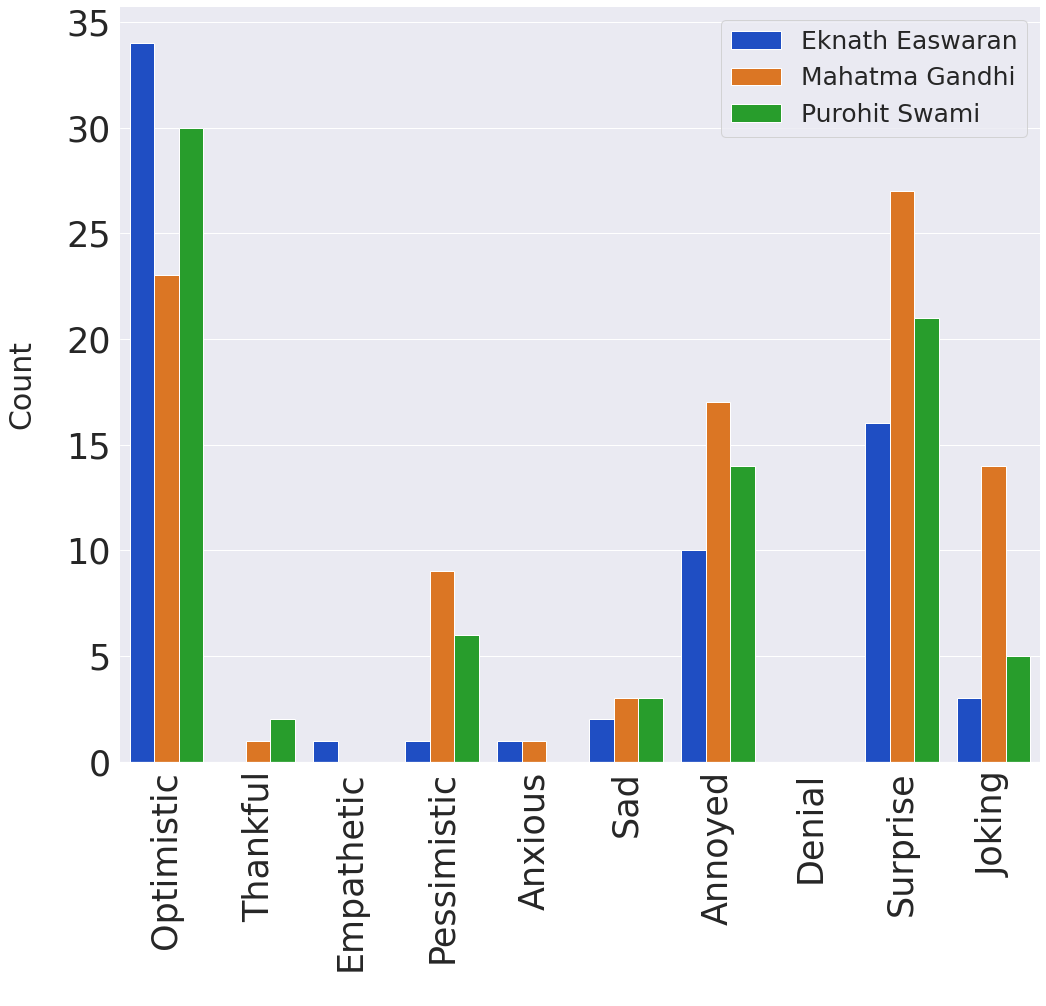

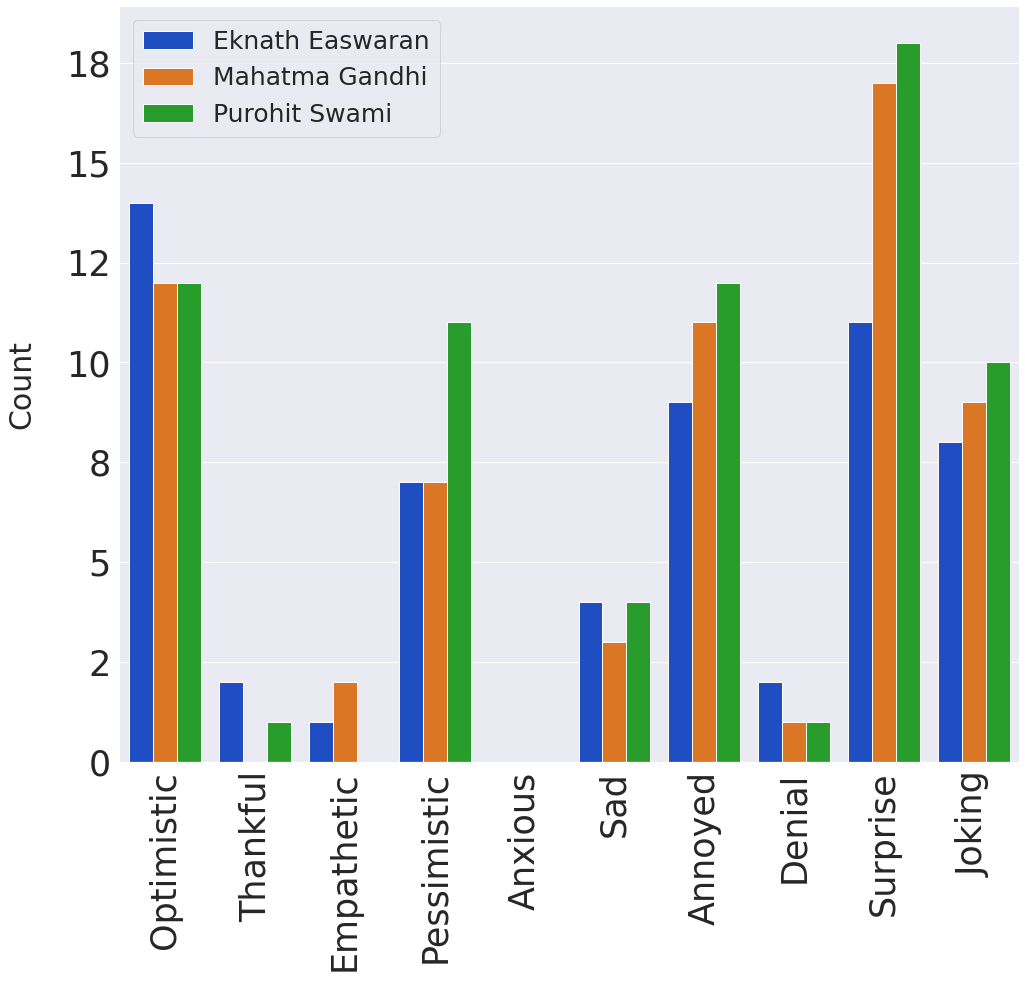

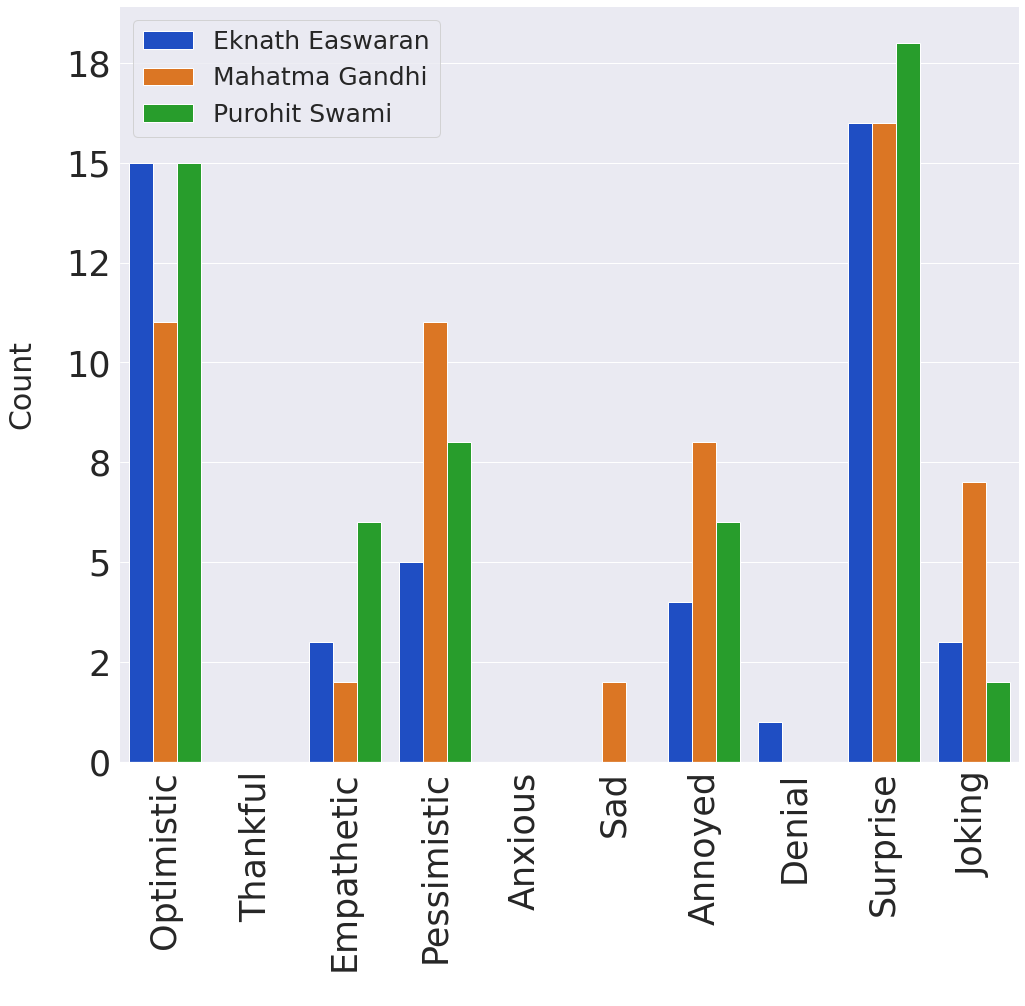

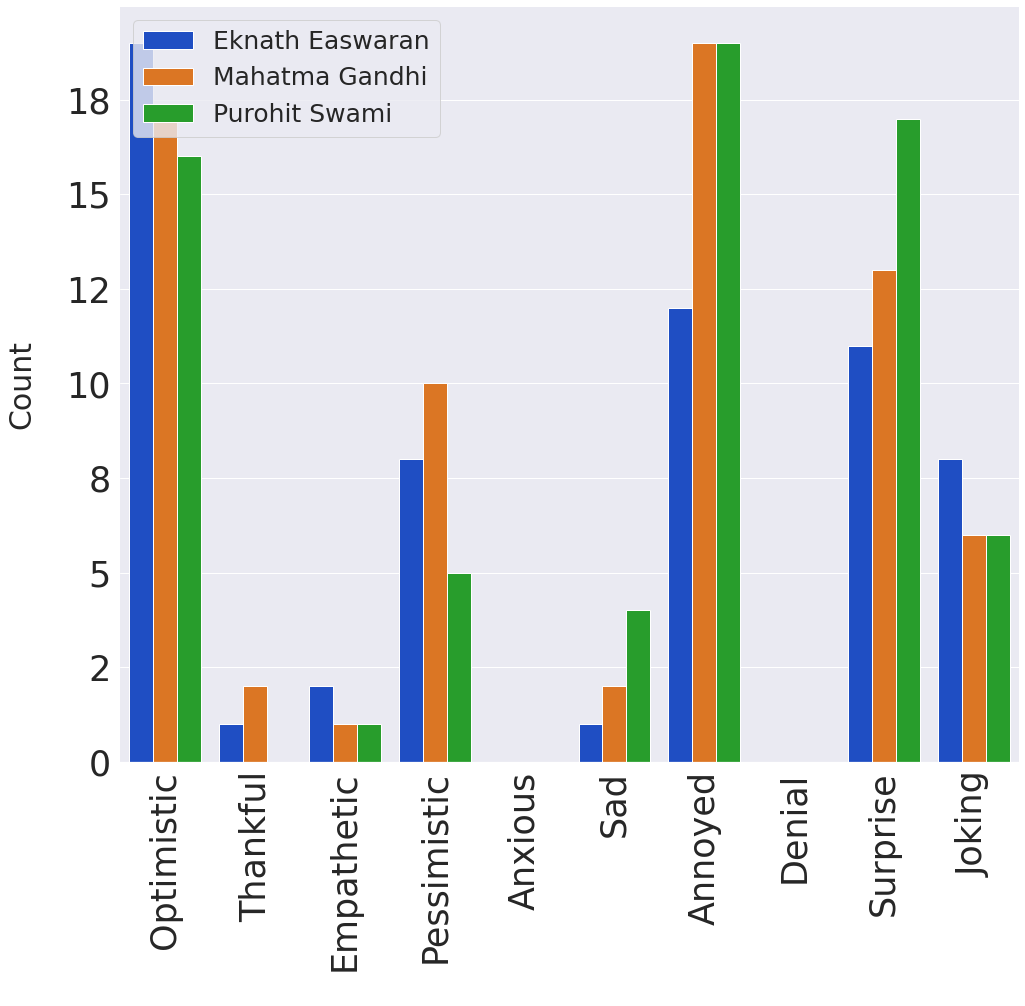

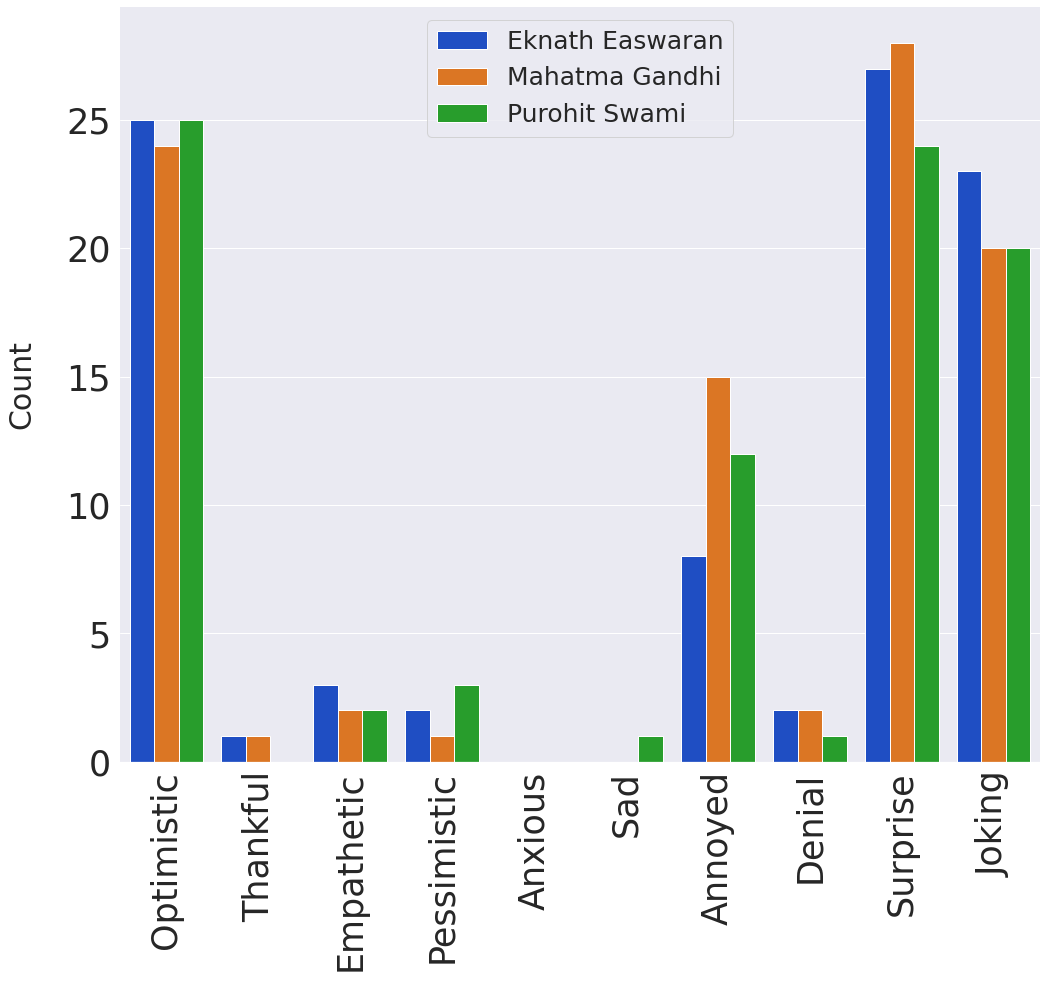

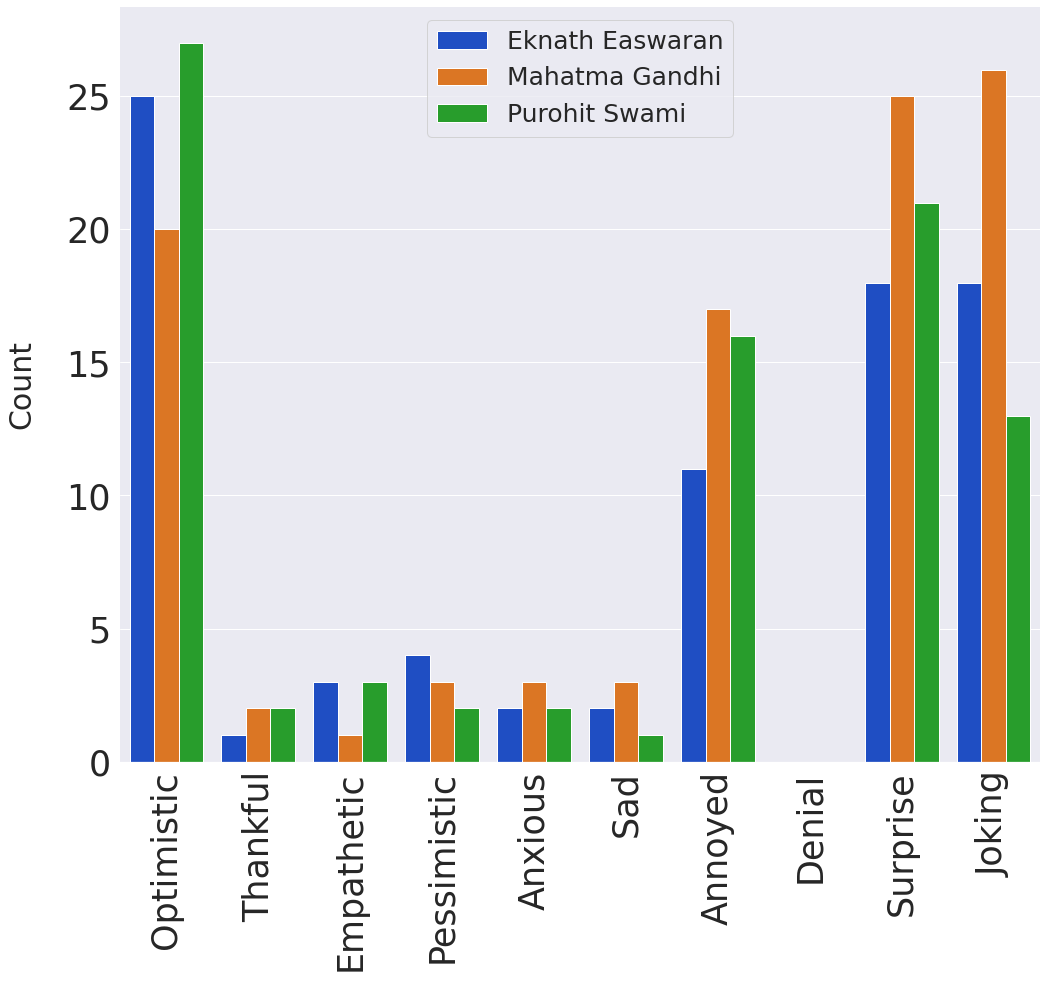

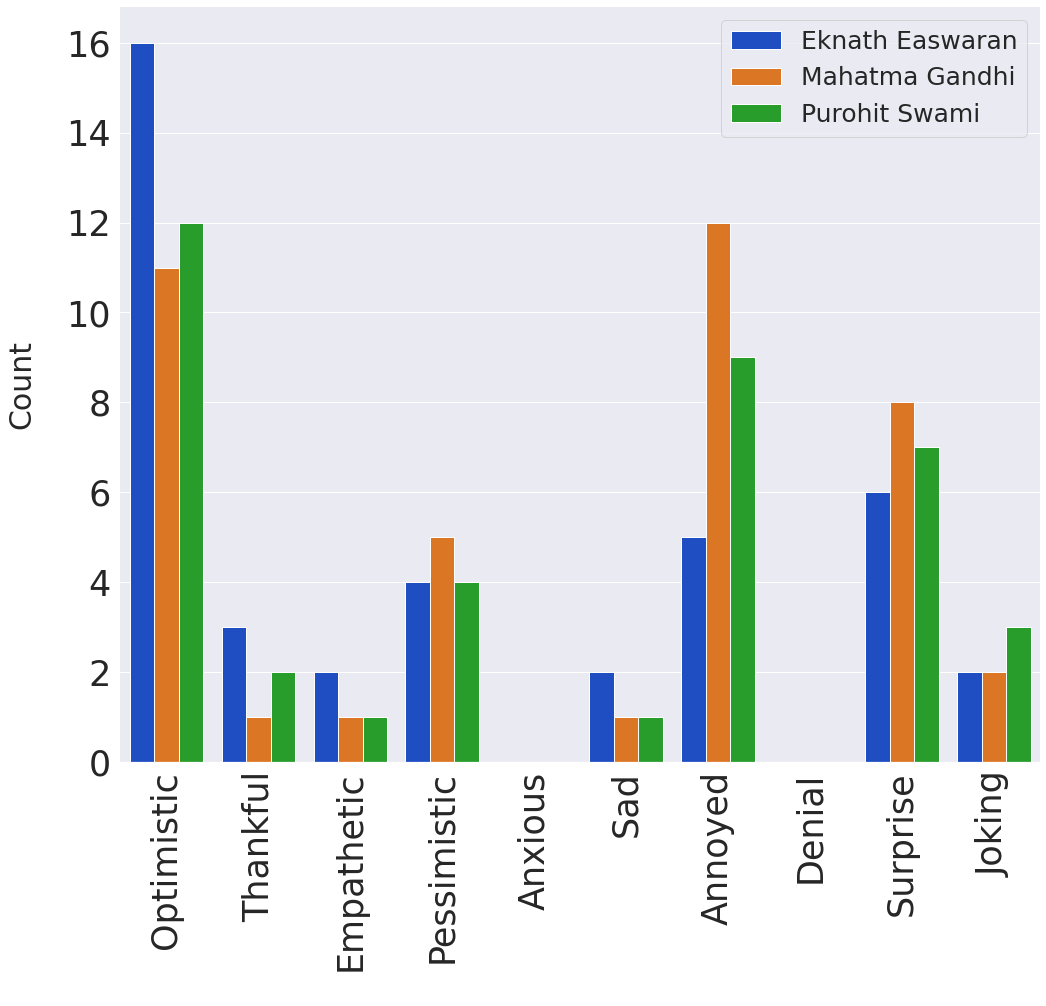

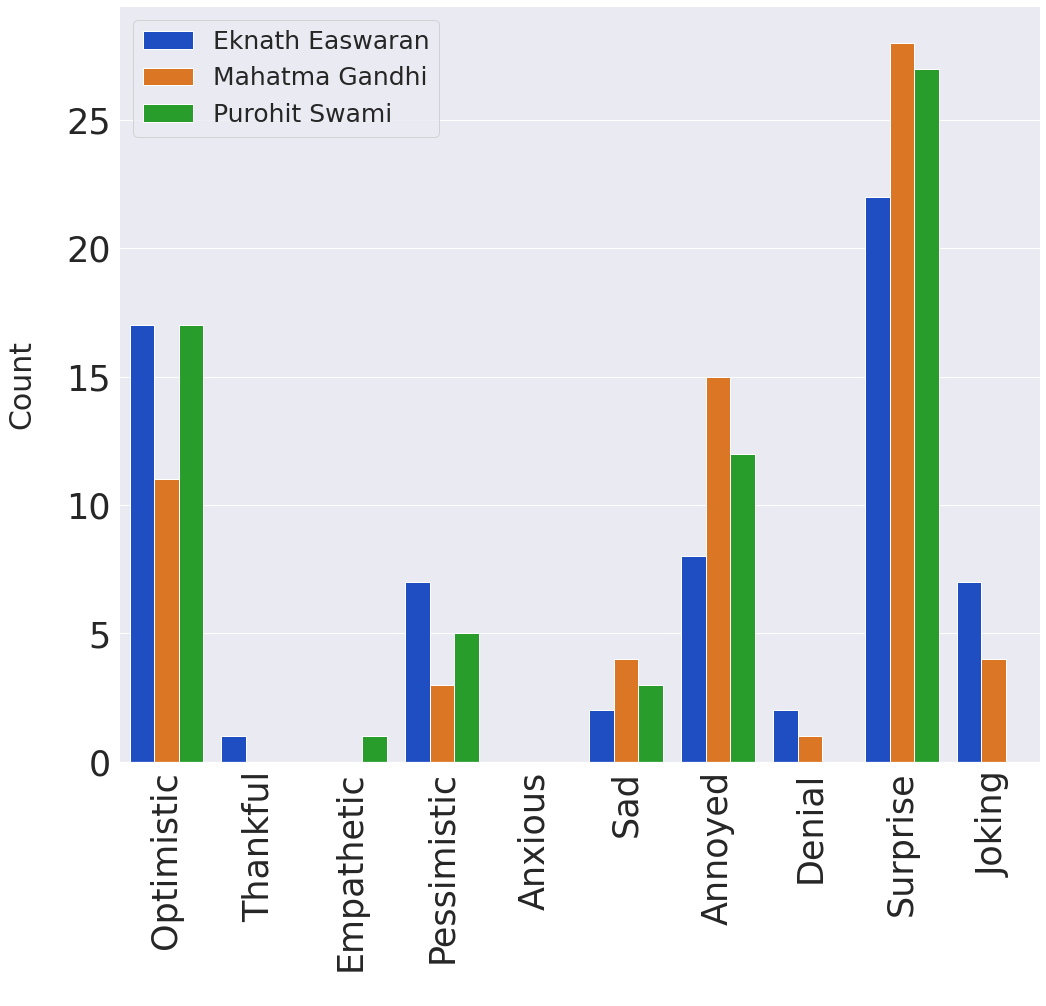

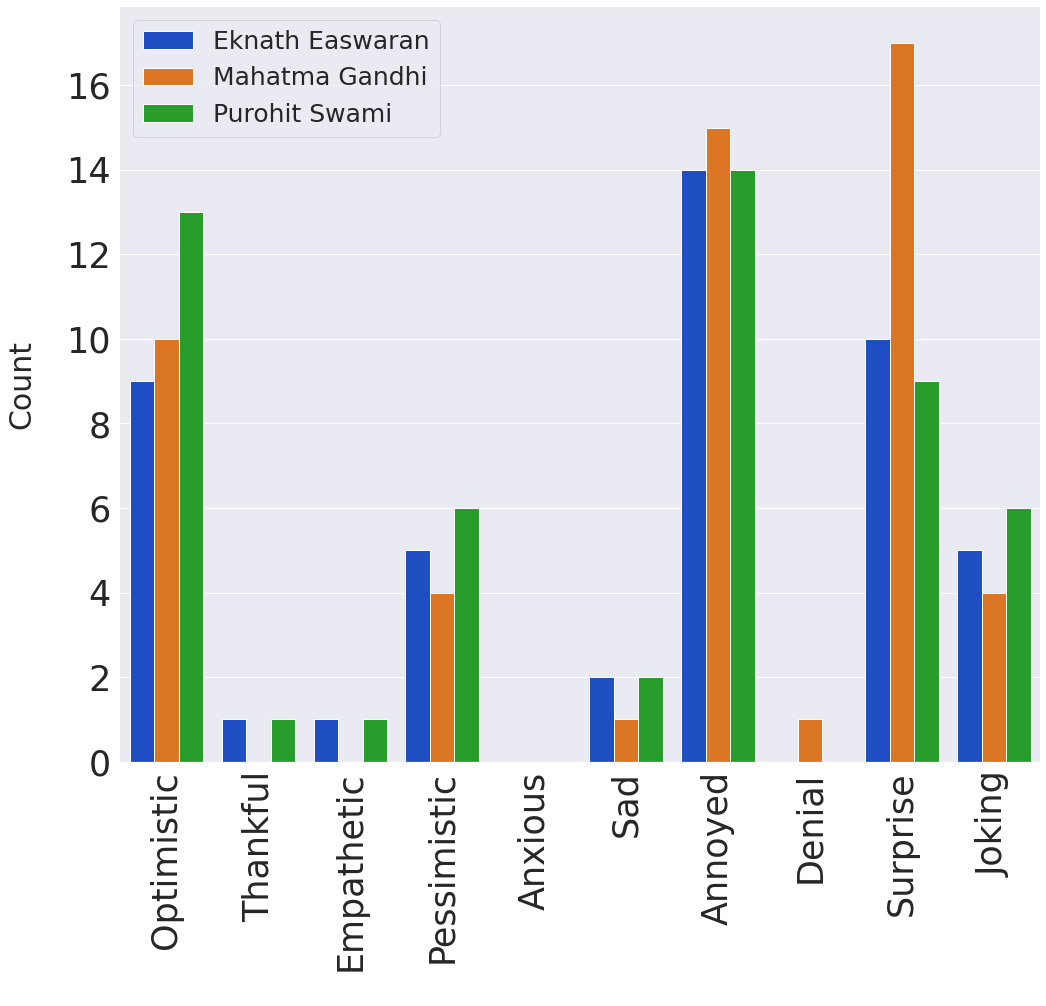

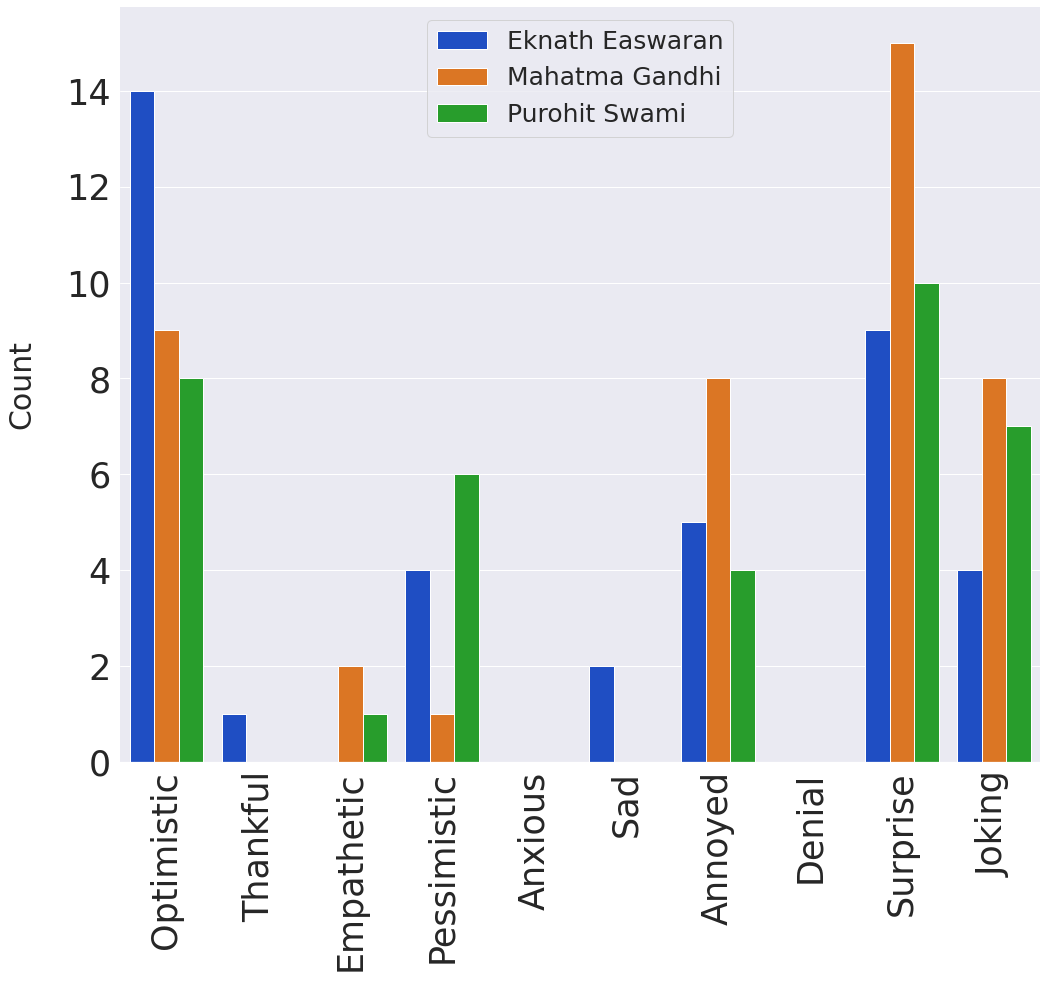

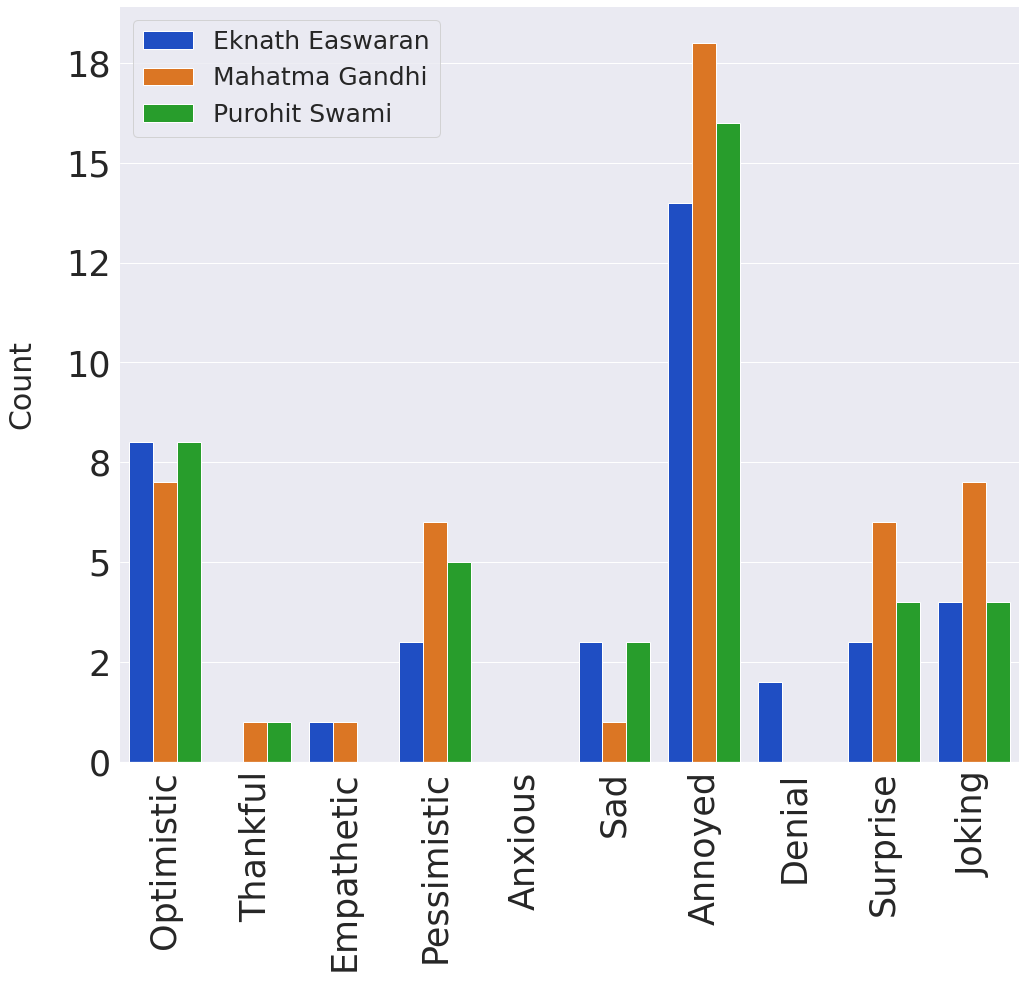

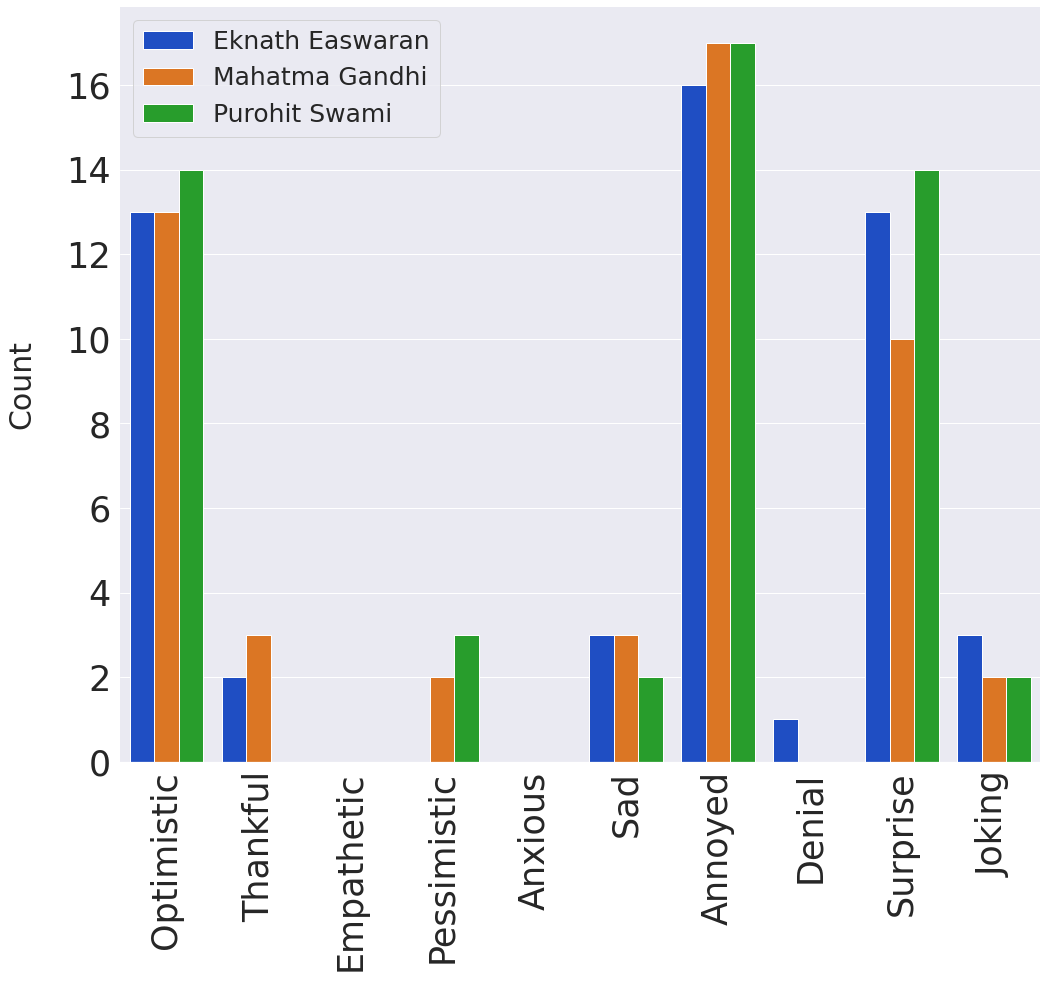

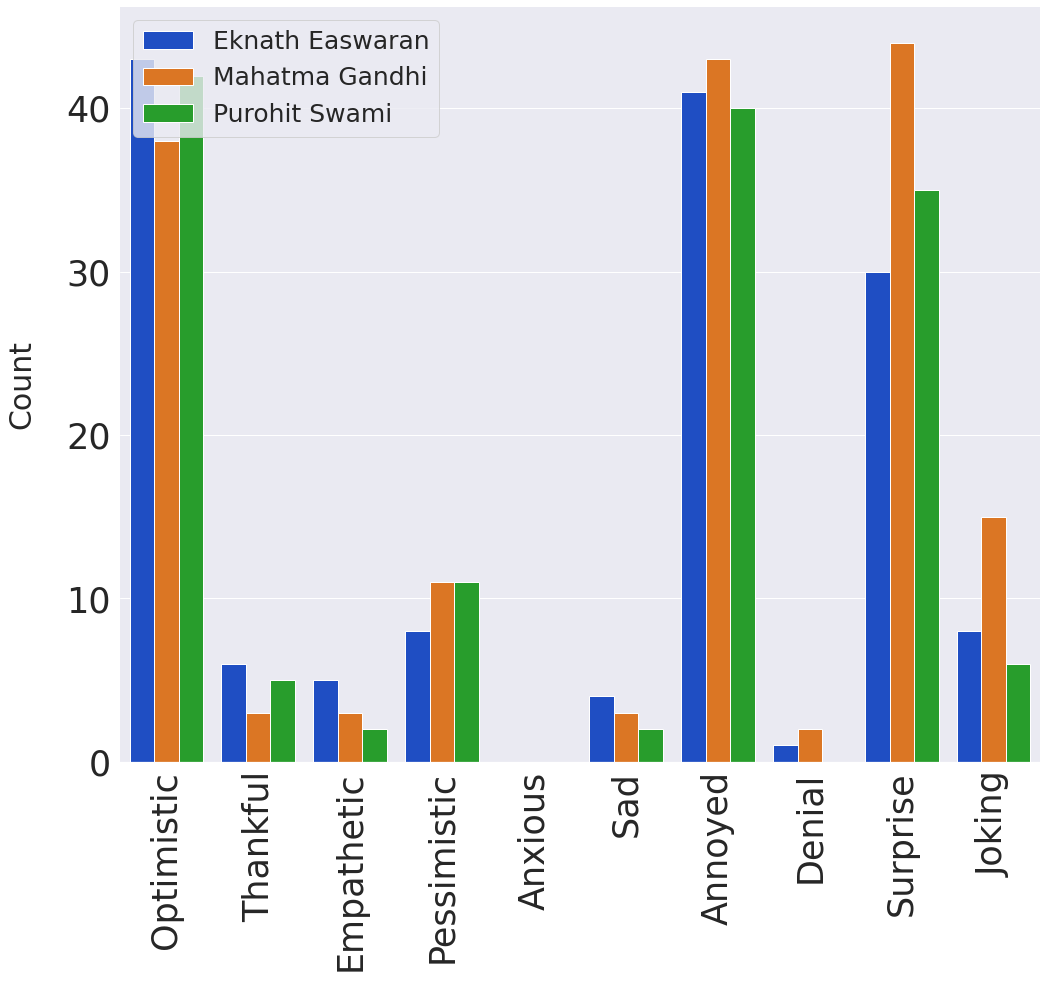

In [ ]:
for chapter in range(1,19):

  eknath_easwaran = chapter_wise_dataframe('/content/drive/MyDrive/religious_texts/eknath easwaran/predicted sentiment/chapter ', chapter)
  mahatma_gandhi = chapter_wise_dataframe('/content/drive/MyDrive/religious_texts/mahatma gandhi/predicted sentiment/chapter ', chapter)
  purohit_swami = chapter_wise_dataframe('/content/drive/MyDrive/religious_texts/purohit swami/predicted sentiment/chapter ', chapter)

  df_new = pd.concat([eknath_easwaran, mahatma_gandhi['Count'], purohit_swami['Count']], axis=1)

  df_new.columns = ['Eknath Easwaran', 'Mahatma Gandhi', 'Purohit Swami'] 

  df_new = df_new.reset_index()

  df_new = df_new.rename(columns={"index":"Sentiment"})

  df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")

  colors = ["blue", "orange", "green"]  
  myPalette = sns.xkcd_palette(colors)

  sns.set_style("darkgrid")
  g = sns.factorplot(x='Sentiment', y='Count', hue='Author', data=df_new, kind='bar', size=12, aspect=1.2, palette = myPalette, legend=False)

  g.despine(left=True)

  # if chapter == 1 or chapter == 2 or chapter == 3 or chapter == 16 or chapter==17:
  #   plt.legend(loc='upper left',prop={"size":25})

  # else:
  #   plt.legend(loc='upper center',prop={"size":25})

  plt.legend(loc='best',prop={"size":25})

  plt.ylabel('Count', labelpad=30, fontsize=30)
  plt.xlabel(' ')

  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))    # format decimals on the y-axis
  plt.yticks(fontsize= 35)
  plt.xticks(fontsize = 35)
  plt.xticks(rotation=90)

  

In [ ]:
df_new.head()

Eknath Easwaran  Mahatma Gandhi  Purohit Swami
Optimistic               7.0             7.0           12.0
Thankful                 5.0             3.0            2.0
Empathetic               1.0             0.0            1.0
Pessimistic              8.0             8.0            5.0
Anxious                  2.0             5.0            2.0

In [ ]:
df_new.reset_index()

index  Eknath Easwaran  Mahatma Gandhi  Purohit Swami
0   Optimistic              7.0             7.0           12.0
1     Thankful              5.0             3.0            2.0
2   Empathetic              1.0             0.0            1.0
3  Pessimistic              8.0             8.0            5.0
4      Anxious              2.0             5.0            2.0
5          Sad              9.0             8.0            7.0
6      Annoyed             20.0            21.0           17.0
7       Denial              0.0             0.0            0.0
8     Surprise             18.0            21.0           19.0
9       Joking             15.0            20.0           15.0

# HeatMaps

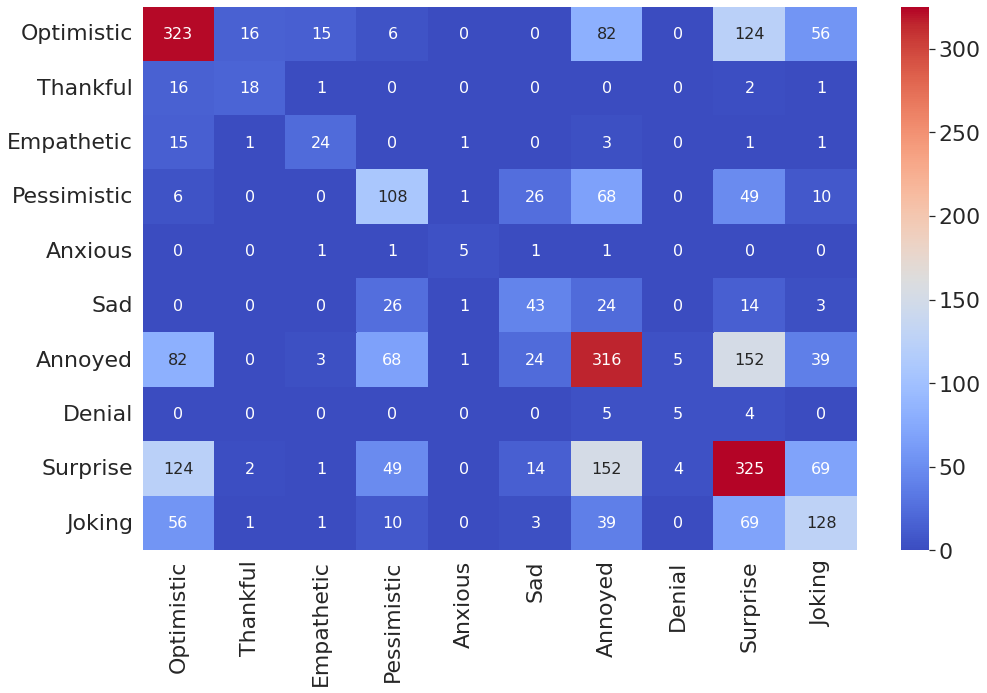

In [ ]:
heatmap_df = pd.read_csv('/content/drive/MyDrive/religious_texts/purohit swami/predicted sentiment/chapter 1')
heatmap_df = heatmap_df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)

for chapter in range(2, 19):
  df = pd.read_csv('/content/drive/MyDrive/religious_texts/purohit swami/predicted sentiment/chapter ' + str(chapter))

  df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)

  heatmap_df = pd.concat([heatmap_df, df], axis=0)

emote_array = np.zeros((10, 10))
e2i = {
    'Optimistic' : 0, 'Thankful' : 1, 'Empathetic' : 2, 'Pessimistic' : 3, 'Anxious' : 4, 'Sad' : 5, 'Annoyed' : 6, 'Denial' : 7,
    'Surprise' : 8, 'Joking' : 9
}

for i in range(len(heatmap_df)):
    l = heatmap_df.iloc[i].tolist()
    for j in range(10):
        if l[j] == 1:
            emote_array[j][j] += 1
        for k in range(j+1, 10):                 # to avoid double counting.
            if (l[j] == 1) and (l[k] == 1):
                emote_array[j][k] += int(1)
                emote_array[k][j] += int(1)

emotions = ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 'Anxious', 'Sad', 'Annoyed', 'Denial', 'Surprise', 'Joking']

emote_df = pd.DataFrame(emote_array, columns = emotions)
for col in emote_df:
    emote_df[col] = emote_df[col].astype(int)

fig = plt.figure(figsize = (16, 10))
sns.set(font_scale=2)
sns.heatmap(emote_df, annot = True, cmap = 'coolwarm', xticklabels = emote_df.columns, yticklabels = emote_df.columns, 
            fmt = 'g', annot_kws = {"size" : 16})
# plt.title('Chapter ' + str(chapter), pad = 25)

# Histplots

In [ ]:
eknath_easwaran = all_chapter_dataframe('/content/drive/MyDrive/religious_texts/eknath easwaran/predicted sentiment/chapter ')
mahatma_gandhi = all_chapter_dataframe('/content/drive/MyDrive/religious_texts/mahatma gandhi/predicted sentiment/chapter ')
purohit_swami = all_chapter_dataframe('/content/drive/MyDrive/religious_texts/purohit swami/predicted sentiment/chapter ')

df_new = pd.concat([eknath_easwaran, mahatma_gandhi['Count'], purohit_swami['Count']], axis=1)

df_new.columns = ['Sentiment', 'Eknath Easwaran', 'Mahatma Gandhi', 'Purohit Swami']

df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")

sns.histplot(data= df_new, x='Sentiment', hue='Author', multiple= 'stack')

In [ ]:
df_new

# Jaccard Similarity Score

In [ ]:
from sklearn.metrics import jaccard_similarity_score, jaccard_score

In [ ]:
eknath_easwaran_chapter_one = pd.read_csv('/content/drive/MyDrive/religious_texts/eknath easwaran/predicted sentiment/chapter 1')
mahatma_gandhi_chapter_one = pd.read_csv('/content/drive/MyDrive/religious_texts/mahatma gandhi/predicted sentiment/chapter 1')
purohit_swami_chapter_one = pd.read_csv('/content/drive/MyDrive/religious_texts/purohit swami/predicted sentiment/chapter 1')

eknath_easwaran_chapter_1 = eknath_easwaran_chapter_one.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
mahatma_gandhi_chapter_1 = mahatma_gandhi_chapter_one.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
purohit_swami_chapter_1 = purohit_swami_chapter_one.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)

In [ ]:
row = eknath_easwaran_chapter_1.iloc[46, :]
row

Optimistic     0.0
Thankful       0.0
Empathetic     0.0
Pessimistic    0.0
Anxious        0.0
Sad            0.0
Annoyed        0.0
Denial         0.0
Surprise       0.0
Joking         0.0
Name: 46, dtype: float64

In [ ]:
purohit_swami_chapter_1.iloc[46, :]

Optimistic     0.0
Thankful       0.0
Empathetic     0.0
Pessimistic    0.0
Anxious        0.0
Sad            0.0
Annoyed        0.0
Denial         0.0
Surprise       0.0
Joking         0.0
Name: 46, dtype: float64

In [ ]:
eknath_easwaran_chapter_1

In [ ]:
import numpy as np
from sklearn.metrics import jaccard_score
y_true = np.array([[0, 1, 1],
                   [1, 1, 0]])
y_pred = np.array([[1, 1, 1],
                   [1, 0, 0]])

# jaccard_similarity_score(y_true, y_pred, normalize=False)



In [ ]:
for ii in range(0, eknath_easwaran_chapter_1.shape[0]):
  print(jaccard_score(eknath_easwaran_chapter_1.iloc[ii, :], purohit_swami_chapter_1.iloc[ii, :]))

Optimistic     0.0
Thankful       0.0
Empathetic     0.0
Pessimistic    0.0
Anxious        0.0
Sad            0.0
Annoyed        1.0
Denial         0.0
Surprise       1.0
Joking         0.0
Name: 0, dtype: float64
Optimistic     0.0
Thankful       0.0
Empathetic     0.0
Pessimistic    0.0
Anxious        0.0
Sad            0.0
Annoyed        0.0
Denial         0.0
Surprise       1.0
Joking         0.0
Name: 0, dtype: float64
0.5
Optimistic     0.0
Thankful       0.0
Empathetic     0.0
Pessimistic    0.0
Anxious        0.0
Sad            0.0
Annoyed        0.0
Denial         0.0
Surprise       1.0
Joking         0.0
Name: 1, dtype: float64
Optimistic     0.0
Thankful       0.0
Empathetic     0.0
Pessimistic    0.0
Anxious        0.0
Sad            0.0
Annoyed        0.0
Denial         0.0
Surprise       1.0
Joking         0.0
Name: 1, dtype: float64
1.0
Optimistic     1.0
Thankful       0.0
Empathetic     0.0
Pessimistic    0.0
Anxious        0.0
Sad            0.0
Annoyed        0.0
Den

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_es_mg = pd.DataFrame()
df_es_ps = pd.DataFrame()
df_mg_ps = pd.DataFrame()

chapter_list = []
es_mg_list = []
es_ps_list = []
mg_ps_list = []

sum1 =0
sum2=0
sum3=0

for chapter in range(1, 19):

  if chapter==1 or chapter==2 or chapter==4 or chapter==6 or chapter==13 or chapter==14 or chapter==18:
    continue

  eknath_easwaran_chapter = pd.read_csv('/content/drive/MyDrive/religious_texts/eknath easwaran/predicted sentiment/chapter ' + str(chapter))
  mahatma_gandhi_chapter = pd.read_csv('/content/drive/MyDrive/religious_texts/mahatma gandhi/predicted sentiment/chapter ' + str(chapter))
  purohit_swami_chapter = pd.read_csv('/content/drive/MyDrive/religious_texts/purohit swami/predicted sentiment/chapter ' + str(chapter))

  eknath_easwaran_chapter = eknath_easwaran_chapter.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
  mahatma_gandhi_chapter = mahatma_gandhi_chapter.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
  purohit_swami_chapter = purohit_swami_chapter.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)

  for ii in range(0, eknath_easwaran_chapter.shape[0]):
    es_ps_list.append(jaccard_score(eknath_easwaran_chapter.iloc[ii, :], purohit_swami_chapter.iloc[ii, :]))
    es_mg_list.append(jaccard_score(eknath_easwaran_chapter.iloc[ii, :], mahatma_gandhi_chapter.iloc[ii, :]))
    mg_ps_list.append(jaccard_score(purohit_swami_chapter.iloc[ii, :], mahatma_gandhi_chapter.iloc[ii, :]))

  df_es_mg1 = pd.DataFrame(chapter_list, columns=['Chapter'])
  df_es_mg2 = pd.DataFrame(es_mg_list, columns=['Easwaran Gandhi'])
  df_es_mg = pd.concat([df_es_mg1, df_es_mg2], axis=1)
  # df_es_mg.to_csv('/content/drive/MyDrive/religious_texts/jaccard score of predicted sentiments/easwaran_gandhi/chapter ' + str(chapter) + '.csv')

  df_es_ps1 = pd.DataFrame(chapter_list, columns=['Chapter'])
  df_es_ps2 = pd.DataFrame(es_ps_list, columns=['Purohit Easwaran'])
  df_es_ps = pd.concat([df_es_ps1, df_es_ps2], axis=1)
  # df_es_ps.to_csv('/content/drive/MyDrive/religious_texts/jaccard score of predicted sentiments/purohit_easwaran/chapter ' + str(chapter) + '.csv')

  df_mg_ps1 = pd.DataFrame(chapter_list, columns=['Chapter'])
  df_mg_ps2 = pd.DataFrame(mg_ps_list, columns=['Purohit Gandhi'])
  df_mg_ps = pd.concat([df_mg_ps1, df_mg_ps2], axis=1)
  # df_mg_ps.to_csv('/content/drive/MyDrive/religious_texts/jaccard score of predicted sentiments/gandhi_purohit/chapter ' + str(chapter) + '.csv')

  print('Chapter ', str(chapter), ' Average')

  print('Easwaran Gandhi ', df_es_mg['Easwaran Gandhi'].mean())
  print('Easwaran Purohit Swami ', df_es_ps['Purohit Easwaran'].mean())
  print('Purohit Swami and Gandhi ', df_mg_ps['Purohit Gandhi'].mean())

  print('\n')

  sum1+=df_es_mg['Easwaran Gandhi'].mean()
  sum2+=df_es_ps['Purohit Easwaran'].mean()
  sum3+=df_mg_ps['Purohit Gandhi'].mean()


Chapter  3  Average
Easwaran Gandhi  0.6042635658914729
Easwaran Purohit Swami  0.5058139534883719
Purohit Swami and Gandhi  0.683720930232558


Chapter  5  Average
Easwaran Gandhi  0.5680555555555556
Easwaran Purohit Swami  0.5196759259259258
Purohit Swami and Gandhi  0.6143518518518519


Chapter  7  Average
Easwaran Gandhi  0.5589869281045753
Easwaran Purohit Swami  0.4885620915032679
Purohit Swami and Gandhi  0.5736928104575166


Chapter  8  Average
Easwaran Gandhi  0.5469230769230767
Easwaran Purohit Swami  0.503205128205128
Purohit Swami and Gandhi  0.5680769230769234


Chapter  9  Average
Easwaran Gandhi  0.5013211382113819
Easwaran Purohit Swami  0.485772357723577
Purohit Swami and Gandhi  0.5647357723577238


Chapter  10  Average
Easwaran Gandhi  0.523462783171521
Easwaran Purohit Swami  0.5068770226537217
Purohit Swami and Gandhi  0.5624595469255665


Chapter  11  Average
Easwaran Gandhi  0.5071519795657725
Easwaran Purohit Swami  0.48780332056194114
Purohit Swami and Gandhi  

In [ ]:
sum1 = sum1/11
sum2 = sum2/11
sum3 = sum3/11

print('sum1 ', sum1)
print('sum2 ', sum2)
print('sum3 ', sum3)

sum1  0.5285112503502581
sum2  0.49698301709817033
sum3  0.562929633367387


In [ ]:
df_es_mg1 = pd.DataFrame(chapter_list, columns=['Chapter'])
df_es_mg2 = pd.DataFrame(es_mg_list, columns=['Easwaran Gandhi'])

df_es_mg = pd.concat([df_es_mg1, df_es_mg2], axis=1)

df_es_mg

Chapter  Easwaran Gandhi
0         3         0.268939
1         5         0.161314
2         7         0.320545
3         8         0.199410
4         9         0.147005
5        10         0.260891
6        11         0.254790
7        12         0.152810
8        15         0.175292
9        16         0.327742
10       17         0.256758

In [ ]:
df_es_ps1 = pd.DataFrame(chapter_list, columns=['Chapter'])
df_es_ps2 = pd.DataFrame(es_ps_list, columns=['Purohit Easwaran'])

df_es_ps = pd.concat([df_es_ps1, df_es_ps2], axis=1)

df_es_ps

Chapter  Purohit Easwaran
0         3          0.178569
1         5          0.175086
2         7          0.293483
3         8          0.246212
4         9          0.192998
5        10          0.301439
6        11          0.228807
7        12          0.217280
8        15          0.245130
9        16          0.248018
10       17          0.188414

In [ ]:
df_mg_ps1 = pd.DataFrame(chapter_list, columns=['Chapter'])
df_mg_ps2 = pd.DataFrame(mg_ps_list, columns=['Purohit Gandhi'])

df_mg_ps = pd.concat([df_mg_ps1, df_mg_ps2], axis=1)

df_mg_ps

Chapter  Purohit Gandhi
0         3        0.261287
1         5        0.192829
2         7        0.348747
3         8        0.236015
4         9        0.324199
5        10        0.278529
6        11        0.198403
7        12        0.265634
8        15        0.243561
9        16        0.330628
10       17        0.255037

In [ ]:
df_final = pd.concat([df_es_mg, df_es_ps['Purohit Easwaran'], df_mg_ps['Purohit Gandhi']], axis=1)

df_final



Chapter  Easwaran Gandhi  Purohit Easwaran  Purohit Gandhi
0         3         0.268939          0.178569        0.261287
1         5         0.161314          0.175086        0.192829
2         7         0.320545          0.293483        0.348747
3         8         0.199410          0.246212        0.236015
4         9         0.147005          0.192998        0.324199
5        10         0.260891          0.301439        0.278529
6        11         0.254790          0.228807        0.198403
7        12         0.152810          0.217280        0.265634
8        15         0.175292          0.245130        0.243561
9        16         0.327742          0.248018        0.330628
10       17         0.256758          0.188414        0.255037

In [ ]:
Easwaran_Gandhi_avg_score = df_final['Easwaran Gandhi'].mean()
Purohit_Easwaran_avg_score = df_final['Purohit Easwaran'].mean()
Purohit_Gandhi_avg_score = df_final['Purohit Gandhi'].mean()

print(Easwaran_Gandhi_avg_score)
print(Purohit_Easwaran_avg_score)
print(Purohit_Gandhi_avg_score)

0.22959057724175366
0.22867606818725064
0.26680619747400475


In [ ]:
data=pd.melt(df_final, ['Chapter'])

In [ ]:
data

Chapter          variable     value
0         3   Easwaran Gandhi  0.268939
1         5   Easwaran Gandhi  0.161314
2         7   Easwaran Gandhi  0.320545
3         8   Easwaran Gandhi  0.199410
4         9   Easwaran Gandhi  0.147005
5        10   Easwaran Gandhi  0.260891
6        11   Easwaran Gandhi  0.254790
7        12   Easwaran Gandhi  0.152810
8        15   Easwaran Gandhi  0.175292
9        16   Easwaran Gandhi  0.327742
10       17   Easwaran Gandhi  0.256758
11        3  Purohit Easwaran  0.178569
12        5  Purohit Easwaran  0.175086
13        7  Purohit Easwaran  0.293483
14        8  Purohit Easwaran  0.246212
15        9  Purohit Easwaran  0.192998
16       10  Purohit Easwaran  0.301439
17       11  Purohit Easwaran  0.228807
18       12  Purohit Easwaran  0.217280
19       15  Purohit Easwaran  0.245130
20       16  Purohit Easwaran  0.248018
21       17  Purohit Easwaran  0.188414
22        3    Purohit Gandhi  0.261287
23        5    Purohit Gandhi  0.192829
24        7    Purohit Gandhi  0.348747
25        8    Purohit Gandhi  0.236015
26        9    Purohit Gandhi  0.324199
27       10    Purohit Gandhi  0.278529
28       11    Purohit Gandhi  0.198403
29       12    Purohit Gandhi  0.265634
30       15    Purohit Gandhi  0.243561
31       16    Purohit Gandhi  0.330628
32       17    Purohit Gandhi  0.255037

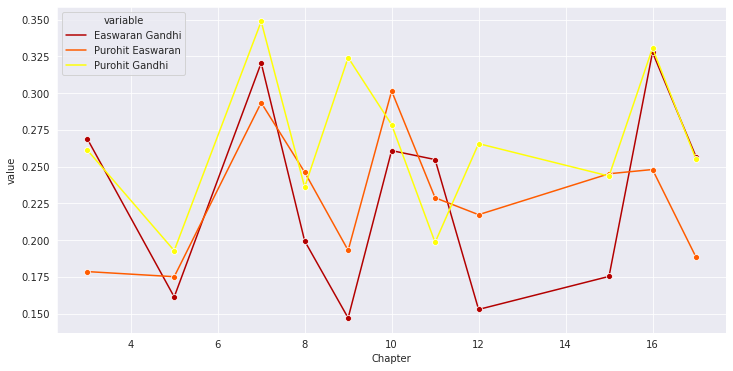

In [ ]:

sns.set_style("darkgrid")

fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
# sns.lineplot(x='Chapter', y='value', hue='variable', data=data, ax = ax)

sns.lineplot(x='Chapter',y='value',  hue = 'variable', data=data,
             palette = 'hot', dashes= False, marker= 'o', ax=ax)

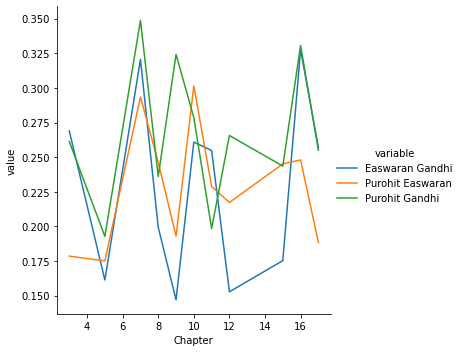

In [ ]:
sns.relplot(x="Chapter", y="value", hue="variable",
            dashes=False, markers=True, kind="line", data=data)

# Variation of Arjuna and Krishna's Sentiments throughout the text

In [ ]:
sentiment_polarity = {
    'Surprise': 0,
    'Joking': 0,
    'Pessimistic': -1,
    'Anxious': -1,
    'Sad':  -1,
    'Annoyed': -1,
    'Denial': -1,
    'Optimistic': 1,
    'Thankful': 1,
    'Empathetic': 1
}

In [ ]:
!python3.7 -m pip install --upgrade pip
!pip install chart_studio
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Plotly to create interactive graph
import chart_studio.plotly as py
from plotly import tools
import plotly.figure_factory as ff
import plotly.graph_objs as go

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 64 kB 2.0 MB/s             


In [ ]:
# Plotly to create interactive graph
import chart_studio.plotly as py
from plotly import tools
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=False)
import plotly.figure_factory as ff
import plotly.graph_objs as go

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

# To remove un-necessary warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']

In [ ]:
# Array of verses in which Arjuna has spoken

array_of_array = [[20,21,22, 27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45], [3,4,5,6,7, 53], [0,1,35], [3], [0], [32,33,36,37,38], [], [0,1], [], 
                  [11,12,13,14,15,16,17], [0,1,2,3,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,35,36,37,38,39,40,41,42,43,44,45],[0], [],[20],[],[],[0],
                  [0,72]]

polarity = 0
count = 0

polarity_array = []
chapter = 1
df_sentiments = pd.DataFrame(columns=['Chapter', 'Polarity'])

for array in array_of_array:

  eknath_easwaran_chapter = pd.read_csv('/content/drive/MyDrive/religious_texts/eknath easwaran/predicted sentiment/chapter ' + str(chapter))

  polarity = 0
  if len(array)!=0:

    for element in array:
      df1 = eknath_easwaran_chapter.loc[element, :]
      if df1['Optimistic'] == 1 :
        count+=1
        polarity+=1

      if df1['Thankful'] == 1 :
        count+=1
        polarity+=1

      if df1['Empathetic'] == 1 :
        count+=1
        polarity+=1

      if df1['Denial'] == 1 :
        count+=1
        polarity -= 1 

      if df1['Annoyed'] == 1 :
        count+=1
        polarity -= 1

      if df1['Sad'] == 1 :
        count+=1
        polarity -= 1

      if df1['Anxious'] == 1 :
        count+=1
        polarity -= 1

      if df1['Pessimistic'] == 1 :
        count+=1
        polarity -= 1

      if df1['Joking'] == 1 :
        #count+=1
        polarity+=0

      if df1['Surprise'] == 1 :
        #count+=1
        polarity+=0

  df_temp = pd.DataFrame([[chapter, polarity]], columns = ['Chapter', 'Polarity'])
  df_sentiments = pd.concat([df_temp, df_sentiments], axis=0, ignore_index = True)
  chapter+=1

df_sentiments = df_sentiments.sort_values('Chapter')

df_sentiments.reset_index()
df_sentiments.set_index('Chapter')


Polarity
Chapter         
1            -33
2             -5
3             -1
4             -1
5              0
6             -3
7              0
8             -1
9              0
10             3
11             7
12             0
13             0
14             0
15             0
16             0
17            -1
18             1

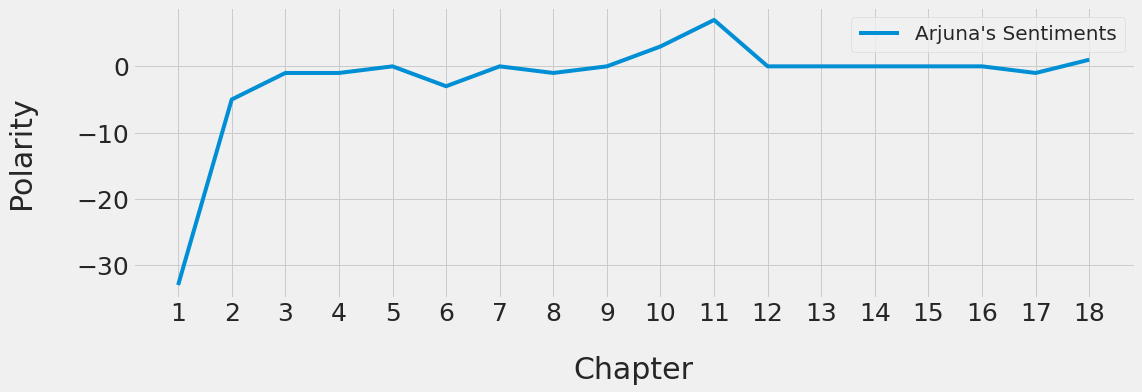

In [ ]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16,5))
p6=sns.lineplot(x = df_sentiments['Chapter'], y = df_sentiments['Polarity'], label='Arjuna\'s Sentiments')
p6.set_xlabel("Verses Where Arjuna Speaks")

plt.ylabel('Polarity', labelpad=40, fontsize=30)
plt.xlabel('Chapter', labelpad=30, fontsize=30)

# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))    # format decimals on the y-axis
plt.yticks(fontsize= 25)
plt.xticks(np.arange(1, 19, step=1), fontsize = 25)

plt.show()


### Krishna's sentiments

In [ ]:
def flatten(lst):
    new_list = []
    for sublist in lst:
      if isinstance(sublist, list):
        for item in sublist:
          new_list.append(item)
      else:
        new_list.append(sublist)

    return new_list     

In [ ]:
array = flatten([2,3, range(11, 54), range(55, 73)])
print(array)

[2, 3, range(11, 54), range(55, 73)]


In [ ]:
array_of_array

[[],
 [2,
  3,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70],
 [3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  37,
  38,
  39,
  40,
  41,
  42],
 [1,
  2,
  3,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42],
 [2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [

In [ ]:
# Array of verses in which Lord Krishna has spoken

array_of_array = [[], flatten([2,3, list(np.arange(11, 54)), list(np.arange(55, 71))]), flatten([list(np.arange(3,36)), list(np.arange(37,43))]), 
                    flatten([1,2,3, list(np.arange(5, 43))]),
                      flatten([list(np.arange(2, 30))]),
                        flatten([list(np.arange(1,33)), 35,36, list(np.arange(40,48))]),
                          flatten([list(np.arange(1,31))]),
                            flatten([list(np.arange(2,29))]),
                              flatten([list(np.arange(1,35))]),
                                flatten([list(np.arange(1,12)), list(np.arange(19,43))]),
                                  flatten([5,6,7,8, 32,33,34,47,48,49,52,53,54,55]),
                                    flatten([list(np.arange(2,21))]),
                                      flatten([list(np.arange(1,35))]),
                                        flatten([list(np.arange(1,21)),22,23,24,25,26,27]),
                                          flatten([list(np.arange(1,21))]),
                                            flatten([list(np.arange(1,25))]),
                                              flatten([list(np.arange(2,29))]),
                                                flatten([list(np.arange(2,73))])]

polarity = 0
count = 0

polarity_array = []
chapter = 1
df_sentiments = pd.DataFrame(columns=['Chapter', 'Polarity'])

for array in array_of_array:

  eknath_easwaran_chapter = pd.read_csv('/content/drive/MyDrive/religious_texts/eknath easwaran/predicted sentiment/chapter ' + str(chapter))

  polarity = 0
  if len(array)!=0:

    for element in array:
      df1 = eknath_easwaran_chapter.loc[element-1, :]
      if df1['Optimistic'] == 1 :
        count+=1
        polarity+=1

      if df1['Thankful'] == 1 :
        count+=1
        polarity+=1

      if df1['Empathetic'] == 1 :
        count+=1
        polarity+=1

      if df1['Denial'] == 1 :
        count+=1
        polarity -= 1 

      if df1['Annoyed'] == 1 :
        count+=1
        polarity -= 1

      if df1['Sad'] == 1 :
        count+=1
        polarity -= 1

      if df1['Anxious'] == 1 :
        count+=1
        polarity -= 1

      if df1['Pessimistic'] == 1 :
        count+=1
        polarity -= 1

      if df1['Joking'] == 1 :
        #count+=1
        polarity+=0

      if df1['Surprise'] == 1 :
        #count+=1
        polarity+=0

  df_temp = pd.DataFrame([[chapter, polarity]], columns = ['Chapter', 'Polarity'])
  df_sentiments = pd.concat([df_temp, df_sentiments], axis=0, ignore_index = True)
  chapter+=1

df_sentiments = df_sentiments.sort_values('Chapter')

df_sentiments.reset_index()
df_sentiments.set_index('Chapter')

Polarity
Chapter         
1              0
2            -26
3            -16
4              4
5              4
6             24
7             -5
8              9
9              1
10            14
11             2
12            10
13            -1
14           -10
15             4
16           -13
17            -4
18            -3

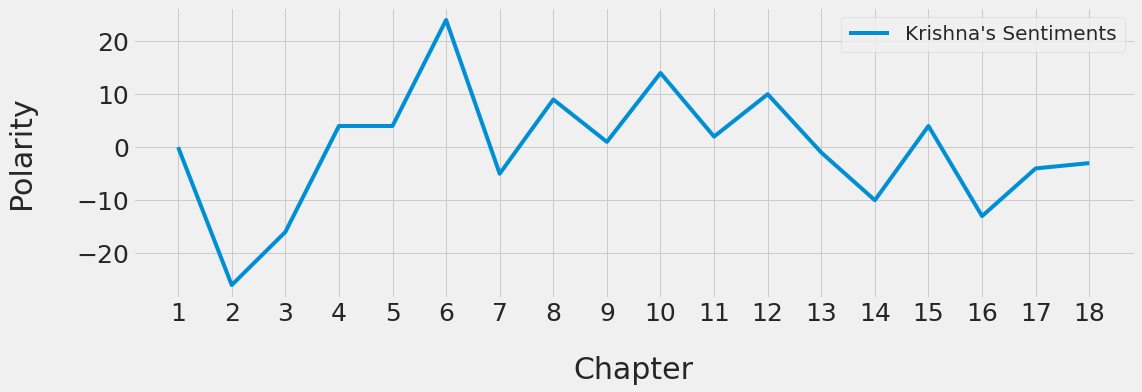

In [ ]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16,5))
p6=sns.lineplot(x = df_sentiments['Chapter'], y = df_sentiments['Polarity'], label='Krishna\'s Sentiments')
p6.set_xlabel("Verses Where Shri Krishna Speaks")

plt.ylabel('Polarity', labelpad=40, fontsize=30)
plt.xlabel('Chapter', labelpad=30, fontsize=30)

# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))    # format decimals on the y-axis
plt.yticks(fontsize= 25)
plt.xticks(np.arange(1, 19, step=1), fontsize = 25)

plt.show()

In [ ]:
eknath_easwaran_chapter = pd.read_csv('/content/drive/MyDrive/religious_texts/eknath easwaran/predicted sentiment/chapter 18')
eknath_easwaran_chapter = eknath_easwaran_chapter.drop(['Unnamed: 0', 'Official report'], axis=1)

eknath_easwaran_chapter.tail(50)


Tweet  ...  Joking
28                                                                                                                                Listen, Arjuna, as I describe the three types of understanding and will.   ...     0.0
29    To know when to act and when to refrain from action, what is right action and what is wrong, what brings security and what insecurity, what brings freedom and what bondage: these are the signs o...  ...     0.0
30                                                                         The rajasic intellect confuses right and wrong actions, and cannot distinguish what is to be done from what should not be done.   ...     0.0
31                                                                                                     The tamasic intellect is shrouded in darkness, utterly reversing right and wrong wherever it turns.   ...     0.0
32                                                                                                         The sattvic will, developed through meditation, keeps prana, mind, and senses in vital harmony.   ...     0.0
33                                                                                                          The rajasic will, conditioned by selfish desire, pursues wealth, pleasure, and respectability.   ...     0.0
34                                                                                                      The tamasic will shows itself in obstinate ignorance, sloth, fear, grief, depression, and conceit.   ...     0.0
35                                                                                       Now listen, Arjuna: there are also three kinds of happiness. By sustained effort, one comes to the end of sorrow.   ...     0.0
36                                                               That which seems like poison at first, but tastes like nectar in the end  this is the joy of sattva, born of a mind at peace with itself.   ...     1.0
37                                                    Pleasure from the senses seems like nectar at first, but it is bitter as poison in the end. This is the kind of happiness that comes to the rajasic.   ...     1.0
38                                                 Those who are tamasic draw their pleasures from sleep, indolence, and intoxication. Both in the beginning and in the end, this happiness is a delusion.   ...     1.0
39                                                                                       No creature, whether born on earth or among the gods in heaven, is free from the conditioning of the three gunas.   ...     0.0
40                                                The different responsibilities found in the social order  distinguishing brahmin, kshatriya, vaishya, and shudra  have their roots in this conditioning.   ...     0.0
41                     The responsibilities to which brahmins are born, based on their nature, are self-control, tranquility, purity of heart, patience, humility, learning, austerity, wisdom, and faith.   ...     0.0
42                             The qualities of kshatriyas, based on their nature, are courage, strength, fortitude, dexterity, generosity, leadership, and the firm resolve never to retreat from battle.   ...     0.0
43                                                                                    The occupations suitable for a vaishya are agriculture, dairying, and trade. The proper work of a shudra is service.   ...     0.0
44                                                                                                           By devotion to ones own particular duty, everyone can attain perfection. Let me tell you how.   ...     0.0
45                                                                     By performing ones own work, one worships the Creator who dwells in every creature. Such worship brings that person to fulfillment.   ...     0.0
46                                 It is better to perform ones own duties 

In [ ]:
df1 = eknath_easwaran_chapter_two.loc[53, :]
df1['Optimistic']

0.0

# Pie Chart for Word Tranformations

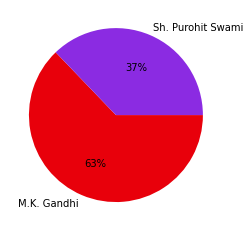

In [ ]:
data = [671, 397]
labels = ['M.K. Gandhi', 'Sh. Purohit Swami']

#define Seaborn color palette to use
colors = sns.color_palette('bright')[3:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%', counterclock = False)
plt.show()


In [ ]:
mahatma_gandhi

Chapter No  Count              Author
0          1.0   33.0      Mahatma Gandhi
1          2.0  104.0      Mahatma Gandhi
2          3.0   25.0      Mahatma Gandhi
3          4.0   14.0      Mahatma Gandhi
4          5.0   37.0      Mahatma Gandhi
5          6.0   50.0      Mahatma Gandhi
6          7.0   30.0      Mahatma Gandhi
7          8.0   41.0      Mahatma Gandhi
8          9.0   44.0      Mahatma Gandhi
9         10.0   42.0      Mahatma Gandhi
10        11.0  155.0      Mahatma Gandhi
11        12.0   20.0      Mahatma Gandhi
12        13.0   41.0      Mahatma Gandhi
13        14.0   55.0      Mahatma Gandhi
14        15.0   16.0      Mahatma Gandhi
15        16.0   16.0      Mahatma Gandhi
16        17.0   39.0      Mahatma Gandhi
17        18.0  120.0      Mahatma Gandhi
18         1.0    2.0  Shri Purohit Swami
19         2.0   45.0  Shri Purohit Swami
20         3.0   13.0  Shri Purohit Swami
21         4.0   30.0  Shri Purohit Swami
22         5.0    2.0  Shri Purohit Swami
23         6.0    6.0  Shri Purohit Swami
24         7.0    8.0  Shri Purohit Swami
25         8.0    9.0  Shri Purohit Swami
26         9.0   26.0  Shri Purohit Swami
27        10.0   28.0  Shri Purohit Swami
28        11.0  121.0  Shri Purohit Swami
29        12.0   18.0  Shri Purohit Swami
30        13.0    3.0  Shri Purohit Swami
31        14.0    1.0  Shri Purohit Swami
32        15.0    1.0  Shri Purohit Swami
33        16.0    8.0  Shri Purohit Swami
34        17.0    0.0  Shri Purohit Swami
35        18.0   53.0  Shri Purohit Swami

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text major ticklabel objects>)

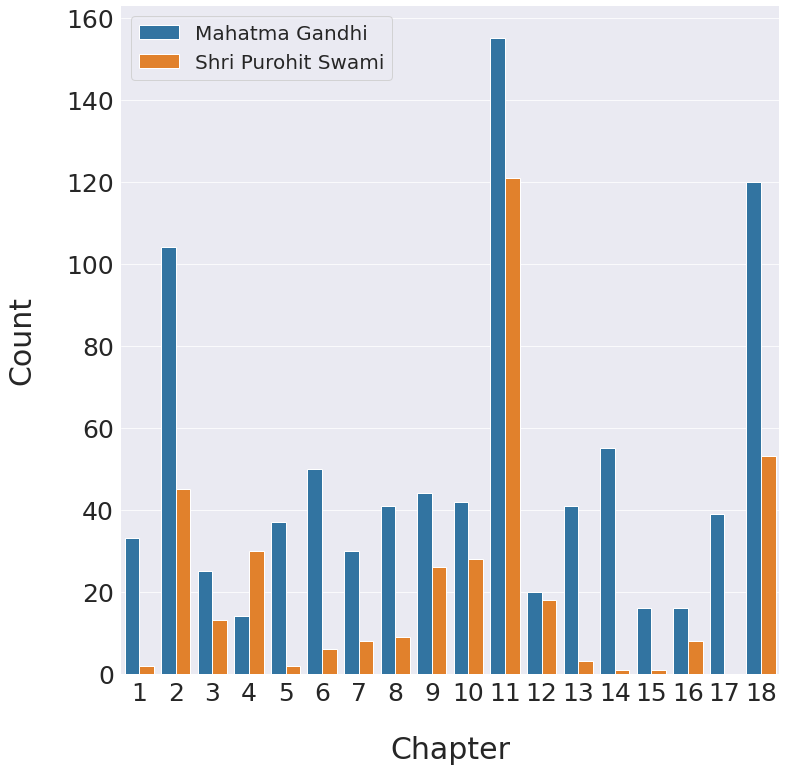

In [ ]:
mahatma_gandhi = pd.read_excel('/content/drive/MyDrive/religious_texts/mahatma gandhi/Mahatma Gandhi.xlsx')
mahatma_gandhi['Chapter No'] = mahatma_gandhi['Chapter No'].astype(int)

sns.color_palette("tab10")

# myPalette = sns.xkcd_palette(colors)

sns.set_style("darkgrid")
g = sns.factorplot(x='Chapter No', y='Count', hue='Author', data=mahatma_gandhi, kind='bar', height=10, legend=False)

g.despine(left=True)

plt.legend(loc='upper left',prop={"size":20})

plt.ylabel('Count', labelpad=30, fontsize=30)
plt.xlabel('Chapter', labelpad=30, fontsize=30)

# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))    # format decimals on the y-axis
plt.yticks(fontsize= 25)
plt.xticks( fontsize = 25)

In [ ]:
mahatma_gandhi

Chapter No  Mahatma Gandhi  Shri Swami Purohit
0            1            33.0                 2.0
1            2           104.0                45.0
2            3            25.0                13.0
3            4            14.0                30.0
4            5            37.0                 2.0
5            6            50.0                 6.0
6            7            30.0                 8.0
7            8            41.0                 9.0
8            9            44.0                26.0
9           10            42.0                28.0
10          11           155.0               121.0
11          12            20.0                18.0
12          13            41.0                 3.0
13          14            55.0                 1.0
14          15            16.0                 1.0
15          16            16.0                 8.0
16          17            39.0                 0.0
17          18           120.0                53.0
18           1             NaN                 NaN
19           2             NaN                 NaN
20           3             NaN                 NaN
21           4             NaN                 NaN
22           5             NaN                 NaN
23           6             NaN                 NaN
24           7             NaN                 NaN
25           8             NaN                 NaN
26           9             NaN                 NaN
27          10             NaN                 NaN
28          11             NaN                 NaN
29          12             NaN                 NaN
30          13             NaN                 NaN
31          14             NaN                 NaN
32          15             NaN                 NaN
33          16             NaN                 NaN
34          17             NaN                 NaN
35          18             NaN                 NaN

# Analyzing classification of Sentiments (experimentation)

In [ ]:
df_chapter_12 = pd.read_csv('/content/drive/MyDrive/religious_texts/eknath easwaran/predicted sentiment/chapter 12')
df_chapter_12.drop(['Unnamed: 0', 'Official report'], axis=1, inplace=True)


In [ ]:
df_gandhi_chapter_12 = pd.read_csv('/content/drive/MyDrive/religious_texts/mahatma gandhi/predicted sentiment/chapter 12')

In [ ]:
df_chapter_12_optimistic = df_chapter_12.loc[(df_chapter_12['Optimistic'] == 1)]
df_chapter_12_annoyed = df_chapter_12.loc[(df_chapter_12['Annoyed'] == 1)]

df_chapter_12_annoyed

In [ ]:
df_chapter_12_optimistic_gandhi = df_gandhi_chapter_12.loc[(df_gandhi_chapter_12['Optimistic'] == 1)]
df_chapter_12_annoyed_gandhi = df_gandhi_chapter_12.loc[(df_gandhi_chapter_12['Annoyed'] == 1)]

df_chapter_12_annoyed_gandhi

In [ ]:
df_gandhi_chapter_2 = pd.read_csv('/content/drive/MyDrive/religious_texts/mahatma gandhi/predicted sentiment/chapter 2')

df_gandhi_chapter_2.head(50)

In [ ]:
df_easwaran_chapter_2 = pd.read_csv('/content/drive/MyDrive/religious_texts/eknath easwaran/predicted sentiment/chapter 2')

df_easwaran_chapter_2.head(50)

# Bigrams - Trigrams

In [ ]:
import gensim
from gensim import utils
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### From Complete Text

In [ ]:
topic_df = pd.read_csv('/content/drive/MyDrive/religious_texts/purohit swami/predicted sentiment/chapter 1')
topic_df = topic_df.drop(['Unnamed: 0', 'Official report'], axis=1)

for chapter in range(2, 19):
  df = pd.read_csv('/content/drive/MyDrive/religious_texts/purohit swami/predicted sentiment/chapter ' + str(chapter))

  df = df.drop(['Unnamed: 0', 'Official report'], axis=1)

  topic_df = pd.concat([topic_df, df], axis=0)

In [ ]:
topic_df2 = pd.read_csv('/content/drive/MyDrive/religious_texts/mahatma gandhi/predicted sentiment/chapter 1')
topic_df2 = topic_df2.drop(['Unnamed: 0', 'Official report'], axis=1)

for chapter in range(2, 19):
  df2 = pd.read_csv('/content/drive/MyDrive/religious_texts/mahatma gandhi/predicted sentiment/chapter ' + str(chapter))

  df2 = df2.drop(['Unnamed: 0', 'Official report'], axis=1)

  topic_df2 = pd.concat([topic_df2, df2], axis=0)

In [ ]:
topic_df2

Tweet  ...  Joking
0     Tell me, O Sanjaya, what my sons and Pandu's...  ...     0.0
1     On seeing the Arjuna's army drawn up in batt...  ...     1.0
2     Behold, O preceptor, this mighty army of the...  ...     0.0
3     Here are brave bowmen, peers of Bhima and Ar...  ...     0.0
4     Dhrishtaketu, Chekitana, valorous Kashiraja,...  ...     0.0
..                                                ...  ...     ...
72    Thus did I hear this marvellous and thrillin...  ...     1.0
73    It was by Vyasa's favor that I listened to t...  ...     0.0
74    O King, as often as I recall that marvellous...  ...     1.0
75    And as often as I recall that marvellous for...  ...     0.0
76    Wheresoever Krishna, the Master of Yoga, is,...  ...     0.0

[697 rows x 11 columns]

In [ ]:
topic_df

Tweet  ...  Joking
0   The King Dhritarashtra asked: “O Sanjaya! What...  ...     0.0
1    Sanjaya replied: “The Prince Duryodhana, when...  ...     0.0
2    Revered Father! Behold this mighty host of th...  ...     0.0
3    In it are heroes and great bowmen; the equals...  ...     1.0
4    Dhrishtaketu, Chekitan, the valiant King of B...  ...     0.0
..                                                ...  ...     ...
72   Sanjaya told: “Thus have I heard this rare, w...  ...     0.0
73   Through the blessing of the sage Vyasa, I lis...  ...     0.0
74   O King! The more I think of that marvellous a...  ...     1.0
75   As memory recalls again and again the exceedi...  ...     0.0
76   Wherever is the Lord Shri Krishna, the Prince...  ...     0.0

[700 rows x 11 columns]

In [ ]:
# Preprocessing functions

# Stopwords
stop_words = stopwords.words('english')
newStopWords = ["shri", "replied", "asked", "shall", "lord", "said"]
stop_words.extend(newStopWords)

def remove_stopwords(tweets):
    return [[word for word in gensim.utils.simple_preprocess(str(tweet)) if word not in stop_words] for tweet in tweets]

def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))


def preprocessing(df):

  df['Tweet'] = df['Tweet'].str.lower()                                                      # Convert to lowercase
  df['Tweet'] = df['Tweet'].str.replace("[^a-zA-Z#]", " ")                                   # Remove punctuations
  df['Tweet'] = df['Tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))     # Remove short words
  df['Tweet tokens'] = list(tokenize(df['Tweet']))
  df['tokens_no_stop'] = remove_stopwords(df['Tweet'])
  df['tokens_no_stop_joined'] = df['Tweet'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in stop_words]))
  return df

def retrieve_text(df):
  doc = '. '.join(df['tokens_no_stop_joined'])
  return doc

def ngrams_series_func(data, n):
  
  wordList = re.sub("[^\w]", " ",  data).split()
  ngrams_series = (pd.Series(nltk.ngrams(wordList, n)).value_counts())[:10]
  return ngrams_series


In [ ]:
# Visualization functions

from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

In [ ]:
stop_words

In [ ]:
topic_df = preprocessing(topic_df)
topic_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The default value of regex will change from True to False in a future version.


Tweet  ...                              tokens_no_stop_joined
0   king dhritarashtra asked sanjaya what happened...  ...  king dhritarashtra sanjaya happened sacred bat...
1   sanjaya replied prince duryodhana when army pa...  ...  sanjaya prince duryodhana army pandavas parade...
2   revered father behold this mighty host pandava...  ...  revered father behold mighty host pandavas par...
3   heroes great bowmen equals battle arjuna bheem...  ...  heroes great bowmen equals battle arjuna bheem...
4   dhrishtaketu chekitan valiant king benares pur...  ...  dhrishtaketu chekitan valiant king benares pur...
..                                                ...  ...                                                ...
72  sanjaya told thus have heard this rare wonderf...  ...  sanjaya told thus heard rare wonderful soul st...
73  through blessing sage vyasa listened this secr...  ...  blessing sage vyasa listened secret noble scie...
74  king more think that marvellous holy discourse...  ...          king think marvellous holy discourse lose
75  memory recalls again again exceeding beauty lo...  ...  memory recalls exceeding beauty filled amazeme...
76  wherever lord shri krishna prince wisdom where...  ...  wherever krishna prince wisdom wherever arjuna...

[700 rows x 14 columns]

In [ ]:
topic_df2 = preprocessing(topic_df2)
topic_df2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The default value of regex will change from True to False in a future version.


Tweet  ...                              tokens_no_stop_joined
0   tell sanjaya what sons pandu assembled battle ...  ...  tell sanjaya sons pandu assembled battle inten...
1   seeing arjuna army drawn battle array king dur...  ...  seeing arjuna army drawn battle array king dur...
2   behold preceptor this mighty army sons pandu a...  ...  behold preceptor mighty army sons pandu array ...
3   here brave bowmen peers bhima arjuna fighting ...  ...  brave bowmen peers bhima arjuna fighting yuyud...
4   dhrishtaketu chekitana valorous kashiraja puru...  ...  dhrishtaketu chekitana valorous kashiraja puru...
..                                                ...  ...                                                ...
72  thus hear this marvellous thrilling discourse ...  ...  thus hear marvellous thrilling discourse krish...
73  vyasa favor that listened this supreme mysteri...  ...  vyasa favor listened supreme mysterious yoga e...
74  king often recall that marvellous purifying di...  ...  king often recall marvellous purifying discour...
75  often recall that marvellous form krishna wond...  ...  often recall marvellous form krishna wonder kn...
76  wheresoever krishna master yoga wheresoever ar...  ...  wheresoever krishna master yoga wheresoever ar...

[697 rows x 14 columns]

In [ ]:
text = retrieve_text(topic_df)
print(text)

king dhritarashtra sanjaya happened sacred battlefield kurukshetra people gathered pandavas. sanjaya prince duryodhana army pandavas paraded approached preceptor guru drona spoke follows. revered father behold mighty host pandavas paraded king drupada wise disciple. heroes great bowmen equals battle arjuna bheema yuyudhana virata drupada great soldiers. dhrishtaketu chekitan valiant king benares purujit kuntibhoja shaibya master many. yudhamanyu uttamouja soubhadra sons droupadi famous. take note captains ranged side best spiritual guides leaders army name. come first bheeshma karna kripa great soldiers ashwaththama vikarna somadhatta. many others ready sake armed skilled. army seems weaker though commanded bheeshma army seems stronger though commanded bheema. therefore rank file stand firm posts according battalions generals bheeshma. enliven spirits brave grandfather bheeshma eldest kuru clan blew conch till sounded like lion roar. immediately conches drums trumpets horns blared fort

In [ ]:
text2 = retrieve_text(topic_df2)
print(text2)

tell sanjaya sons pandu assembled battle intent field kuru field duty sanjaya. seeing arjuna army drawn battle array king duryodhana approached drona preceptor addressed thus. behold preceptor mighty army sons pandu array drupada wise disciple. brave bowmen peers bhima arjuna fighting yuyudhana virata maharatha drupada. dhrishtaketu chekitana valorous kashiraja purujit kuntibhoja shaibya chief among. valiant yudhamanyu valorous uttamaujas subhadra sons draupadi maharatha. acquaint best brahmanas distinguished among mention information names captains army. noble self bhishma karna kripa victorious battle ashvatthaman vikarna also somadatta. many another hero known skill wielding diverse weapons pledged life sake adepts. force commanded bhishma inadequate commanded bhima quite adequate. therefore holding appointed places every entrance guard bhishma. heroic grandsire grand kurus gave loud lion roar blew conch hearten duryodhana. thereupon conches drums cymbals trumpets sounded terrific n

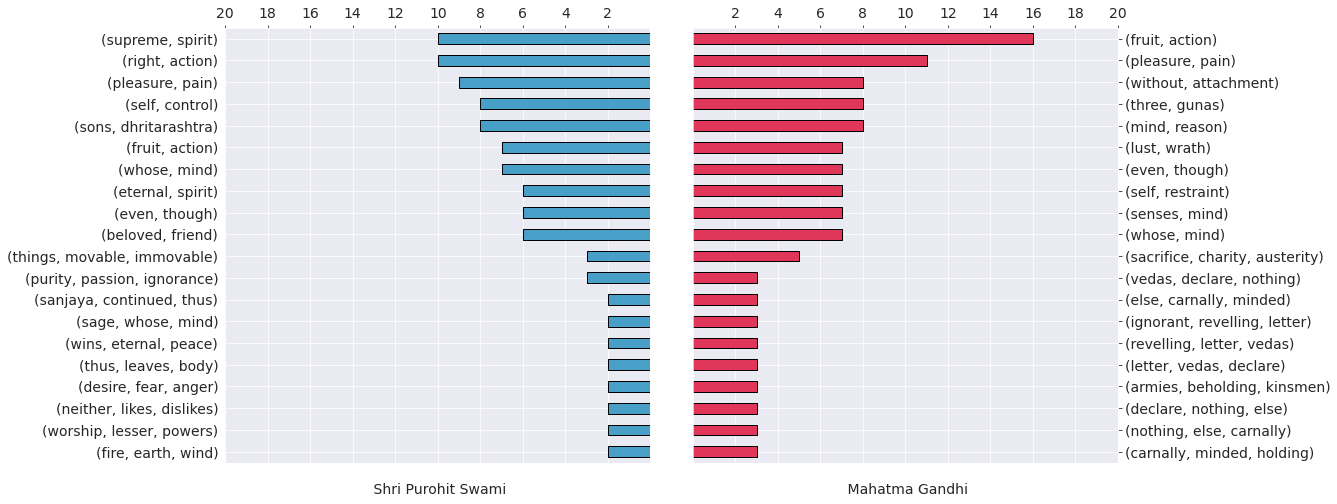

In [ ]:
# uncomment the commented code for generating bigram-trigrams for single text

ticks = [2,4,6,8,10,12,14,16,18,20]

bigram1 = ngrams_series_func(text, 2)
trigram1 = ngrams_series_func(text, 3)

bigram2 = ngrams_series_func(text2, 2)
trigram2 = ngrams_series_func(text2, 3)

ngram1 = pd.concat([bigram1, trigram1])
ngram2 = pd.concat([bigram2, trigram2])

plt.rcParams.update({'font.size': 14})
fig, ax=plt.subplots(1,2, figsize=(16,8), gridspec_kw = {'width_ratios':[1,1], 'wspace':0.1, 'hspace':0.1})
# fig, ax=plt.subplots(1,1, figsize=(8,8))

barh_ax = ax[0]
# barh_ax = ax

ngram1[::-1].plot.barh(ax=barh_ax, color=barcolors[3],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('\n Shri Purohit Swami')
barh_ax.set_ylabel('',fontsize=50)
barh_ax.set_xticks(ticks, minor=False)

barh_ax = ax[1]
ngram2[::-1].plot.barh(ax=barh_ax, color=barcolors[6],**barstyle)
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
barh_ax.set_xlim(barh_ax.get_xlim())
barh_ax.yaxis.tick_right()
barh_ax.set_ylabel('', fontsize=50)
barh_ax.set_xlabel('\n Mahatma Gandhi')
barh_ax.set_xticks(ticks, minor=False)

plt.show()

### From Given Sentiments

In [ ]:
topic_df = pd.read_csv('/content/drive/MyDrive/religious_texts/purohit swami/predicted sentiment/chapter 1')
topic_df = topic_df.drop(['Unnamed: 0', 'Official report'], axis=1)

for chapter in range(2, 19):
  df = pd.read_csv('/content/drive/MyDrive/religious_texts/purohit swami/predicted sentiment/chapter ' + str(chapter))

  df = df.drop(['Unnamed: 0', 'Official report'], axis=1)

  topic_df = pd.concat([topic_df, df], axis=0)

In [ ]:
# Preprocessing functions

# Stopwords
# stop_words = stopwords.words('english')

# def remove_stopwords(tweets):
#     return [[word for word in gensim.utils.simple_preprocess(str(tweet)) if word not in stop_words] for tweet in tweets]

# def tokenize(tweet):
#     for word in tweet:
#         yield(gensim.utils.simple_preprocess(str(word), deacc=True))


# def preprocessing(df):

#   df['Tweet'] = df['Tweet'].str.lower()                                                      # Convert to lowercase
#   df['Tweet'] = df['Tweet'].str.replace("[^a-zA-Z#]", " ")                                   # Remove punctuations
#   df['Tweet'] = df['Tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))     # Remove short words
#   df['Tweet tokens'] = list(tokenize(df['Tweet']))
#   df['tokens_no_stop'] = remove_stopwords(df['Tweet'])
#   df['tokens_no_stop_joined'] = df['Tweet'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in stop_words]))
#   return df

# def retrieve_text(df):
#   doc = '. '.join(df['tokens_no_stop_joined'])
#   return doc

# def ngrams_series_func(data, n):
  
#   wordList = re.sub("[^\w]", " ",  data).split()
#   ngrams_series = (pd.Series(nltk.ngrams(wordList, n)).value_counts())[:10]
#   return ngrams_series

In [ ]:
# Visualization functions

from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

In [ ]:
topic_df = preprocessing(topic_df)
topic_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The default value of regex will change from True to False in a future version.


Tweet  ...                              tokens_no_stop_joined
0   king dhritarashtra asked sanjaya what happened...  ...  king dhritarashtra sanjaya happened sacred bat...
1   sanjaya replied prince duryodhana when army pa...  ...  sanjaya prince duryodhana army pandavas parade...
2   revered father behold this mighty host pandava...  ...  revered father behold mighty host pandavas par...
3   heroes great bowmen equals battle arjuna bheem...  ...  heroes great bowmen equals battle arjuna bheem...
4   dhrishtaketu chekitan valiant king benares pur...  ...  dhrishtaketu chekitan valiant king benares pur...
..                                                ...  ...                                                ...
72  sanjaya told thus have heard this rare wonderf...  ...  sanjaya told thus heard rare wonderful soul st...
73  through blessing sage vyasa listened this secr...  ...  blessing sage vyasa listened secret noble scie...
74  king more think that marvellous holy discourse...  ...          king think marvellous holy discourse lose
75  memory recalls again again exceeding beauty lo...  ...  memory recalls exceeding beauty filled amazeme...
76  wherever lord shri krishna prince wisdom where...  ...  wherever krishna prince wisdom wherever arjuna...

[700 rows x 14 columns]

In [ ]:
df_optimistic = topic_df[topic_df['Optimistic'] == 1]
df_pessimistic = topic_df[topic_df['Pessimistic'] == 1]
df_surprise = topic_df[topic_df['Surprise'] == 1]
df_denial = topic_df[topic_df['Denial'] == 1]
df_annoyed = topic_df[topic_df['Annoyed'] == 1]
df_thankful = topic_df[topic_df['Thankful'] == 1]
df_empathetic = topic_df[topic_df['Empathetic'] == 1]
df_anxious = topic_df[topic_df['Anxious'] == 1]
df_sad =  topic_df[topic_df['Sad'] == 1]
df_joking = topic_df[topic_df['Joking'] == 1]

In [ ]:
text_optimistic = '. '.join(df_optimistic.tokens_no_stop_joined)
text_pessimistic = '. '.join(df_pessimistic.tokens_no_stop_joined)
text_surprise = '. '.join(df_surprise.tokens_no_stop_joined)
text_denial = '. '.join(df_denial.tokens_no_stop_joined)
text_annoyed = '. '.join(df_annoyed.tokens_no_stop_joined)
text_thankful = '. '.join(df_thankful.tokens_no_stop_joined)
text_empathetic = '. '.join(df_empathetic.tokens_no_stop_joined)
text_anxious = '. '.join(df_anxious.tokens_no_stop_joined)
text_sad = '. '.join(df_sad.tokens_no_stop_joined)
text_joking = '. '.join(df_joking.tokens_no_stop_joined)

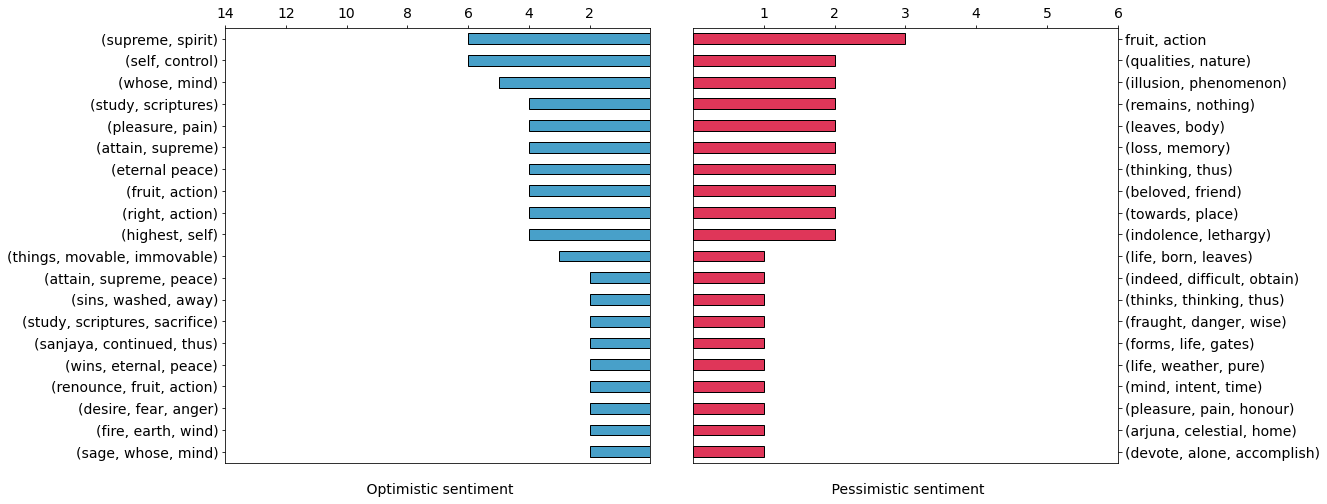

In [ ]:
# bigram1 = ngrams_series_func(text_optimistic, 2)
# trigram1 = ngrams_series_func(text_optimistic, 3)

# print(bigram1)
ticks = [2,4,6,8,10,12,14]

# bigram2 = ngrams_series_func(text_pessimistic, 2)
# print(bigram2)
# trigram2 = ngrams_series_func(text_pessimistic, 3)

ngram1 = pd.concat([bigram1, trigram1])
ngram2 = pd.concat([bigram2, trigram2])

plt.rcParams.update({'font.size': 14})
fig, ax=plt.subplots(1,2, figsize=(16,8), gridspec_kw = {'width_ratios':[1,1], 'wspace':0.1, 'hspace':0.1})

barh_ax = ax[0]
ngram1[::-1].plot.barh(ax=barh_ax, color=barcolors[3],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
# barh_ax.xaxis.set_major_formatter(formatterK2)
# barh_ax.set_xlim([0, 1200])
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('\n Optimistic sentiment')
barh_ax.set_ylabel('',fontsize=50)
barh_ax.set_xticks(ticks, minor=False)

barh_ax = ax[1]
ngram2[::-1].plot.barh(ax=barh_ax, color=barcolors[6],**barstyle)
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
# barh_ax.xaxis.set_major_formatter(formatterK2)
# barh_ax.set_xlim([0, 1200])
barh_ax.set_xlim(barh_ax.get_xlim())
barh_ax.yaxis.tick_right()
# barh_ax.set_xlabel('Tri N-gram Count - Trump Dataset', fontsize=13)
barh_ax.set_ylabel('', fontsize=50)
barh_ax.set_xlabel('\n Pessimistic sentiment')
barh_ax.set_xticks([1,2,3,4,5,6], minor=False)
plt.show()

In [ ]:
bigram2 = pd.Series({'fruit, action': 3,
'(qualities, nature)': 2,
'(illusion, phenomenon)': 2,
'(remains, nothing)' :     2,
'(leaves, body)':          2,
'(loss, memory)' :        2,
'(thinking, thus)':       2,
'(beloved, friend)':      2,
'(towards, place)':         2,
'(indolence, lethargy)':     2})

trigram2 = pd.Series({
'(life, born, leaves)': 1,
'(indeed, difficult, obtain)': 1,
'(thinks, thinking, thus)': 1,
'(fraught, danger, wise)': 1,
'(forms, life, gates)': 1,
'(life, weather, pure)': 1,
'(mind, intent, time)': 1,
'(pleasure, pain, honour)': 1,
'(arjuna, celestial, home)': 1,
'(devote, alone, accomplish)': 1
})

bigram1 = pd.Series({
    '(supreme, spirit)':  6,
    '(self, control)':  6,
    '(whose, mind)':  5,
    '(study, scriptures)':  4,
    '(pleasure, pain)':  4,
    '(attain, supreme)':  4,
    '(eternal peace)':  4,
    '(fruit, action)':  4,
    '(right, action)':  4,
    '(highest, self)':  4
})

trigram1 = pd.Series({
    '(things, movable, immovable)':  3,
    '(attain, supreme, peace)':   2,
    '(sins, washed, away)':   2,
    '(study, scriptures, sacrifice)':   2,
    '(sanjaya, continued, thus)':   2,
    '(wins, eternal, peace)':   2,
    '(renounce, fruit, action)':   2,
    '(desire, fear, anger)':   2,
    '(fire, earth, wind)':   2,
    '(sage, whose, mind)':   2
})

# Comparing Chapters with stark differences in Predicted Sentiments

In [ ]:
eknath_easwaran_6 = pd.read_csv('/content/drive/MyDrive/religious_texts/eknath easwaran/predicted sentiment/chapter 6')
mahatma_gandhi_6 = pd.read_csv('/content/drive/MyDrive/religious_texts/mahatma gandhi/predicted sentiment/chapter 6')
purohit_swami_6 = pd.read_csv('/content/drive/MyDrive/religious_texts/purohit swami/predicted sentiment/chapter 6')

In [ ]:
eknath_easwaran_6.drop(['Unnamed: 0', 'Official report'], axis=1, inplace=True)
eknath_easwaran_6

In [ ]:
mahatma_gandhi_6

In [ ]:
purohit_swami_6.drop(['Unnamed: 0', 'Official report'], axis=1, inplace=True)
purohit_swami_6

In [ ]:
df_complete = pd.DataFrame()

for chapter in range(1, 19):

  if chapter==1 or chapter==2 or chapter==4 or chapter==6 or chapter==13 or chapter==14 or chapter==18:
    continue

  eknath_easwaran_chapter = pd.read_csv('/content/drive/MyDrive/religious_texts/eknath easwaran/predicted sentiment/chapter ' + str(chapter))
  mahatma_gandhi_chapter = pd.read_csv('/content/drive/MyDrive/religious_texts/mahatma gandhi/predicted sentiment/chapter ' + str(chapter))
  purohit_swami_chapter = pd.read_csv('/content/drive/MyDrive/religious_texts/purohit swami/predicted sentiment/chapter ' + str(chapter))

  eknath_easwaran_chapter['Chapter'] = chapter
  mahatma_gandhi_chapter['Chapter'] = chapter
  purohit_swami_chapter['Chapter'] = chapter

  df = pd.merge(eknath_easwaran_chapter, mahatma_gandhi_chapter, left_index=True, right_index=True)
  df = pd.merge(df, purohit_swami_chapter, left_index=True, right_index=True)

  df_complete = pd.concat([df_complete, df])

In [ ]:
df_joking = df_complete.loc[(df_complete['Joking_x']==1) & (df_complete['Joking_y']==1) & (df_complete['Joking']==1)]
# df_joking = df[['Tweet_x', 'Tweet_y', 'Tweet']]
df_joking

# Creation of Data with All the Results

In [ ]:
df_purohit = pd.read_csv('/content/drive/MyDrive/religious_texts/purohit swami/predicted sentiment/chapter 1')
df_purohit.head(5)

Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   
4           4   

                                                                                                                                                Tweet  \
0   The King Dhritarashtra asked: “O Sanjaya! What happened on the sacred battlefield of Kurukshetra, when my people gathered against the Pandavas?”    
1   Sanjaya replied: “The Prince Duryodhana, when he saw the army of the Pandavas paraded, approached his preceptor Guru Drona and spoke as follows:    
2                                   Revered Father! Behold this mighty host of the Pandavas, paraded by the son of King Drupada, your wise disciple.    
3                   In it are heroes and great bowmen; the equals in battle of Arjuna and Bheema, Yuyudhana, Virata and Drupada, great soldiers all;    
4                                            Dhrishtaketu, Chekitan, the valiant King of Benares, Purujit, Kuntibhoja, Shaibya – a master over many;    

   Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
1         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
2         1.0       1.0         0.0          0.0      0.0  0.0      0.0   
3         0.0       1.0         0.0          0.0      0.0  0.0      0.0   
4         1.0       0.0         0.0          0.0      0.0  0.0      0.0   

   Denial  Official report  Surprise  Joking  
0     0.0              0.0       1.0     0.0  
1     0.0              0.0       1.0     0.0  
2     0.0              0.0       0.0     0.0  
3     0.0              0.0       1.0     1.0  
4     0.0              0.0       0.0     0.0

In [ ]:
sentiments = ['Optimistic', 'Thankful', 'Empathetic',
              'Pessimistic', 'Anxious', 'Sad', 'Annoyed', 'Denial', 'Surprise', 'Joking']

def return_sentiments(data, row):

    text = ''

    for sentiment in sentiments:
      if data[sentiment][row] == 1:
        text+=sentiment
        text+=', '

    # print(text)
    return text

In [ ]:
sentiments = ['Optimistic', 'Thankful', 'Empathetic',
              'Pessimistic', 'Anxious', 'Sad', 'Annoyed', 'Denial', 'Surprise', 'Joking']
# data = pd.DataFrame(columns = ['Chapter', 'Verse No.', 'Author', 'Verse', 'Sentiment 1', 'Sentiment 2', 'Sentiment 3', 'Sentiment 4', 
#                                 'Sentiment 5', 'Sentiment 6', 'Easwaran vs Gandhi', 'Gandhi vs Purohit', 'Purohit vs Easwaran'])

data = pd.DataFrame(columns = ['Chapter', 'Verse No.', 'Author', 'Verse', 'Predicted Sentiments', 'Easwaran vs Gandhi', 'Gandhi vs Purohit', 'Purohit vs Easwaran'])

count = 0

for chapter in range(1, 19):

  if chapter==1 or chapter==2 or chapter==4 or chapter==6 or chapter==13 or chapter==14 or chapter==18:
    continue

  semantic_comparsion = pd.read_csv('/content/drive/MyDrive/religious_texts/semantic analysis/all-mpnet-base-v2/cosine_similarity.csv')

  df_purohit = pd.read_csv('/content/drive/MyDrive/religious_texts/purohit swami/predicted sentiment/chapter ' + str(chapter))
  df_purohit = df_purohit.drop(['Unnamed: 0', 'Official report'], axis=1)

  df_easwaran = pd.read_csv('/content/drive/MyDrive/religious_texts/eknath easwaran/predicted sentiment/chapter ' + str(chapter))
  df_easwaran = df_easwaran.drop(['Unnamed: 0', 'Official report'], axis=1)

  df_gandhi = pd.read_csv('/content/drive/MyDrive/religious_texts/mahatma gandhi/predicted sentiment/chapter ' + str(chapter))
  df_gandhi = df_gandhi.drop(['Unnamed: 0', 'Official report'], axis=1)

  for ii in range(3*df_gandhi.shape[0]):
    if ii%3==0:
        pr_sentiments = return_sentiments(df_easwaran, ii//3)
        
        ## enclose the values in [], a list must be passed. Do not pass a scalar! 
        dict2 = {'Chapter': [chapter], 'Verse No.': [ii//3+1], 'Author':['Eknath Easwaran'], 'Verse': [df_easwaran['Tweet'][ii//3]], 'Predicted Sentiments': [pr_sentiments],
                  'Easwaran vs Gandhi':[semantic_comparsion['Easwaran - Gandhi'][ii//3]], 'Gandhi vs Purohit':[semantic_comparsion['Gandhi - Purohit'][ii//3]],
                    'Purohit vs Easwaran': [semantic_comparsion['Purohit - Easwaran'][ii//3]]}

        df_temp = pd.DataFrame(dict2)
        data=pd.concat([data, df_temp], ignore_index=True)

    elif ii%3==1:
        pr_sentiments = return_sentiments(df_gandhi, ii//3)
        dict2 = {'Chapter': [' '], 'Verse No.': [ii//3+1], 'Author':['Mahatma Gandhi'], 'Verse': [df_gandhi['Tweet'][ii//3]], 'Predicted Sentiments': [pr_sentiments],
                 'Easwaran vs Gandhi':[' '], 'Gandhi vs Purohit':[' '],
                    'Purohit vs Easwaran': [' ']}
        df_temp = pd.DataFrame(dict2)
        data=pd.concat([data, df_temp], ignore_index=True)

    else:
        pr_sentiments = return_sentiments(df_purohit, ii//3)
        dict2 = {'Chapter': [' '], 'Verse No.': [ii//3+1], 'Author':['Shri Purohit Swami'], 'Verse': [df_purohit['Tweet'][ii//3]], 'Predicted Sentiments': [pr_sentiments],
                 'Easwaran vs Gandhi':[' '], 'Gandhi vs Purohit':[' '],
                    'Purohit vs Easwaran': [' ']}

        df_temp = pd.DataFrame(dict2)
        data=pd.concat([data, df_temp], ignore_index=True)

data.head(20)    

Chapter Verse No.              Author  \
0        3         1     Eknath Easwaran   
1                  1      Mahatma Gandhi   
2                  1  Shri Purohit Swami   
3        3         2     Eknath Easwaran   
4                  2      Mahatma Gandhi   
5                  2  Shri Purohit Swami   
6        3         3     Eknath Easwaran   
7                  3      Mahatma Gandhi   
8                  3  Shri Purohit Swami   
9        3         4     Eknath Easwaran   
10                 4      Mahatma Gandhi   
11                 4  Shri Purohit Swami   
12       3         5     Eknath Easwaran   
13                 5      Mahatma Gandhi   
14                 5  Shri Purohit Swami   
15       3         6     Eknath Easwaran   
16                 6      Mahatma Gandhi   
17                 6  Shri Purohit Swami   
18       3         7     Eknath Easwaran   
19                 7      Mahatma Gandhi   

                                                                                                                                                                                                 Verse  \
0                                                                          ARJUNA:  O Krishna, you have said that knowledge is greater than action; why then do you ask me to wage this terrible war?    
1                                                          If, O Krishna, you hold that the attitude of detachment is superior to  action, then why, O Krishna, do you urge me to dreadful action?       
2                                                                                      “Arjuna questioned: My Lord! If Wisdom is above action, why do You advise me to engage in this terrible fight?    
3                                                                                                                     Your advice seems inconsistent. Give me one path to follow to the supreme good.    
4                           You do seem to confuse my understanding with perplexing speech; tell  me, therefore, in no uncertain voice, that alone whereby I may attain salvation.   The Lord Said:      
5                                                Your language perplexes me and confuses my reason. Therefore please tell me the only way by which I may, without doubt, secure my spiritual welfare.    
6            KRISHNA:  At the beginning of time I declared two paths for the pure heart: jnana yoga, the contemplative path of spiritual wisdom, and karma yoga, the active path of selfless service.    
7                                                     I have spoken, before, O sinless one, of two attitudes in this world—the  Sankhayas', that of Jnana yoga and the Yogins', that of karma yoga.      
8    Lord Shri Krishna replied: In this world, as I have said, there is a twofold path, O Sinless One! There is the Path of Wisdom for those who meditate, and the Path of Action for those who work.    
9                                                                                                  One who shirks action does not attain freedom; no one can gain perfection by abstaining from work.    
10                                                             Never does man enjoy freedom from action by not undertaking action, nor  does he attain that freedom by mere renunciation of action.      
11                                                                          No man can attain freedom from activity by refraining from action; nor can he reach perfection by merely refusing to act.    
12                                                                                     Indeed, there is no one who rests for even an instant; all creatures are driven to action by their own nature.    
13                                                                            For none ever remains inactive even for a moment; for all are compelled to  action by the gunas inherent in prakriti.      
14                                              

In [ ]:
data.to_csv('/content/drive/MyDrive/religious_texts/COMBINED_DATA.csv')

In [ ]:
df_easwaran['Tweet'][0]

'ARJUNA:  O Krishna, you have said that knowledge is greater than action; why then do you ask me to wage this terrible war? '